# Network regularisation and preprocessing

In this tutorial we'll build directly on top of what we did in the amplitude regression task in the previous tutorial.  The first goal is to learn about the issue of over-training, and how to overcome it with network regularisation and early stopping. The second goal is to learn more about the different types of preprocessing that can be used in machine learning.

#### Outline / tasks:
 - Imports \& plotting set-up
 - Loading the data
     - limit the training data to just 1000 events, keeping 30k for validation and testing
     - this is unrealistic, but a good way to understand over-fitting and how to fix it
 - Visualising the data
 - Preprocessing the data
 - Datasets and dataloaders
     - choose a sensible batch size, say 64
 - Building the neural network
     - use a larger network, say 3 layers with hidden dimensions of 50
 - Optimising (training) the neural network
     - train for a long time, 1000-1500 epochs
 - Plot the train and validation losses as a function of the epochs
     - now you should clearly see the over-training problem
 - Network regularisation
     - Dropout
         - implement a new network, amp_net_dr, which has a pytorch dropout layer after the input layer and each hidden layer
         - re-train the network and check if dropout has fixed the over-fitting
     - L1 / L2 regularisation
     - Early stopping
     - Batch normalisation
 - Exploring preprocessing options
     - check what happens if you don't preprocess your data at all..
     - Look at the scikit-learn package a try out a few different data preprocessing functions, e.g. StandardScaler
     - See how these affect the data visualisations
     - Find preprocessing functions that are suitable for the 4-momentum inputs, and some that are suitable for the amplitudes

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

#### Plotting set-up

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True

## Loading the data

In [3]:
trn_dat = np.load( "tutorial-2-data/trn_dat.npy" )
trn_amp = np.load( "tutorial-2-data/trn_amp.npy" )

val_dat = np.load( "tutorial-2-data/val_dat.npy" )
val_amp = np.load( "tutorial-2-data/val_amp.npy" )

tst_dat = np.load( "tutorial-2-data/tst_dat.npy" )
tst_amp = np.load( "tutorial-2-data/tst_amp.npy" )

In [4]:
print( f"train data shape: {trn_dat.shape}" )
print( f"train amp  shape: {trn_amp.shape}" )
print( f"test  data shape: {tst_dat.shape}" )
print( f"test  amp  shape: {tst_amp.shape}" )
print( f"val   data shape: {val_dat.shape}" )
print( f"val   amp  shape: {val_amp.shape}" )

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


Let's say we have much less data:

In [5]:
trn_dat = trn_dat[0:1000]
trn_amp = trn_amp[0:1000]
print( f"train data shape: {trn_dat.shape}" )
print( f"train amp  shape: {trn_amp.shape}" )

train data shape: (1000, 5, 4)
train amp  shape: (1000,)


This is slightly unrealistic, but useful for demonstration purposes.  In practice we might use much larger networks than we use here, and so the number of parameters can be of the same order of magnitude as the number of training events.  This is when we encounter the problem of over-training.

## Visualising the data

Below we will make some kinematic plots of the events in the training sample.  Note however that these are not the physical distributions we would measure at the LHC!  In our training data each of these events is associated with an amplitude, which tells us the probability that the event will be produced in the gluon-gluon interaction.  So to get the physical distributions these events would need to be 'weighted' by their amplitude.  However, right now we just want to visualise our training dataset to see what preprocessing we should do.

In [6]:
def get_init_pz( ev ):
    return ev[0][3] + ev[1][3]

def get_mass( fv ):
    msq = np.round( fv[0]**2 - fv[1]**2 - fv[2]**2 - fv[3]**2 , 5 )
    if msq>0:
        return np.sqrt( msq )
    elif msq<0:
        raise Exception( "mass squared is less than zero" ) 
    else:
        return 0
    
def get_pt( fv ):
    ptsq = np.round( fv[1]**2 + fv[2]**2 , 5 )
    if ptsq>0:
        return np.sqrt( ptsq )
    elif ptsq<0:
        raise Exception( "$p_T$ squared is less than zero" ) 
    else:
        return 0
    
def get_met( ev ):
    return np.abs( np.sum( [ fv[1]+fv[2] for fv in ev ] ) )

We can plot a histogram of the amplitudes for the training data.

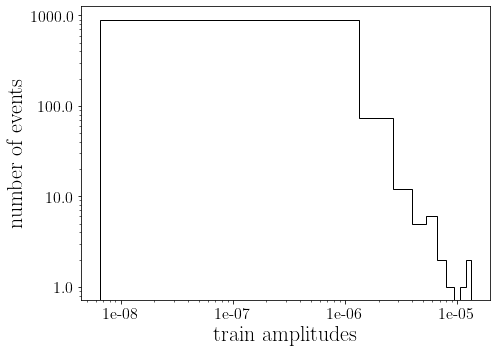

In [7]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.hist( trn_amp, histtype='stepfilled', fill=None )

axs.set_yscale( 'log' )
axs.set_xscale( 'log' )

axs.set_xlabel( "train amplitudes", fontproperties=axislabelfont )
axs.set_ylabel( "number of events", fontproperties=axislabelfont )

xticks = axs.get_xticks()
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

fig.tight_layout()

The amplitudes span about 4 orders of magnitude...

Plotting the leading photon $p_T$.

In [8]:
trn_dat_leading_photon_pt = []
for ev in trn_dat:
    trn_dat_leading_photon_pt.append( get_pt( ev[2] ) )

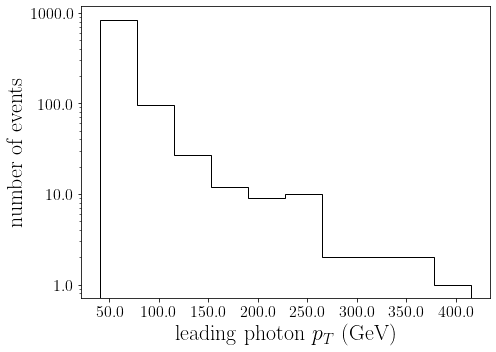

In [9]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.hist( trn_dat_leading_photon_pt, histtype='stepfilled', fill=None )

axs.set_yscale( 'log' )

axs.set_xlabel( "leading photon $p_T$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "number of events", fontproperties=axislabelfont )

xticks = axs.get_xticks()
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

fig.tight_layout()

Plot the final state gluon $p_T$.

In [10]:
trn_dat_gluon_pt = []
for ev in trn_dat:
    trn_dat_gluon_pt.append( get_pt( ev[4] ) )

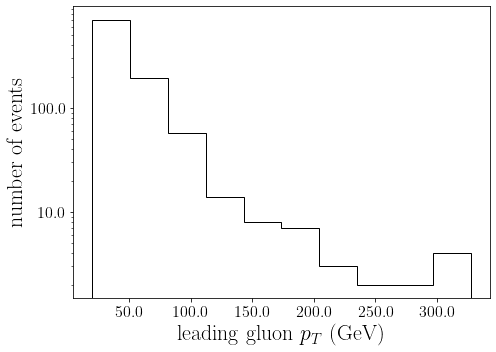

In [11]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.hist( trn_dat_gluon_pt, histtype='stepfilled', fill=None )

axs.set_yscale( 'log' )

axs.set_xlabel( "leading gluon $p_T$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "number of events", fontproperties=axislabelfont )

xticks = axs.get_xticks()
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

fig.tight_layout()

## Preprocessing the data

We will be using a dense network, so the data needs to be in vector format.  We will collapse the data for each event to a single vector of dimension $5\times4=20$.  The fact that the data is ordered here is important.  To predict the amplitude given the kinematics, the network needs to know which entries correspond to which particles in the process.

In [12]:
trn_nev = trn_dat.shape[0]
val_nev = val_dat.shape[0]
tst_nev = tst_dat.shape[0]
trn_datf = np.reshape( trn_dat, (trn_nev,-1) )
val_datf = np.reshape( val_dat, (val_nev,-1) )
tst_datf = np.reshape( tst_dat, (tst_nev,-1) )

Check the shape:

In [13]:
trn_datf.shape

(1000, 20)

There are further preprocessing steps we can take.  For example, the inputs are numerically very large $\mathcal{O}(100)$ and span a large range.  So we could re-scale the inputs by a constant number, or even take the logarithm of the inputs.

For now, we'll just re-scale by a constant number, the average final state gluon $p_T$, assuming that this is a natural scale for the problem.  And we should be careful to preprocess the train, validation, and test data in the exact same way.

In [14]:
trn_dat_gluon_pt = []
for ev in trn_dat:
    trn_dat_gluon_pt.append( get_pt( ev[4] ) )

In [15]:
gpt = np.mean( trn_dat_gluon_pt )
trn_datf = trn_datf / gpt
val_datf = val_datf / gpt
tst_datf = tst_datf / gpt

Now convert them to pytorch tensors.

In [16]:
trn_datfp = torch.Tensor( trn_datf )
val_datfp = torch.Tensor( val_datf )
tst_datfp = torch.Tensor( tst_datf )

We should also preprocess the amplitude data.  As we seen in a plot above, the amplitudes span about 4 orders of magnitude.  This could be difficult for the network to interpolate.  We can aleviate the problem with preprocessing, taking the logarithm of the amplitudes.

In [17]:
trn_ampl = np.log( trn_amp )
val_ampl = np.log( val_amp )
tst_ampl = np.log( tst_amp )

In [18]:
trn_amplp = torch.Tensor( trn_ampl )
val_amplp = torch.Tensor( val_ampl )
tst_amplp = torch.Tensor( tst_ampl )

The new distribution looks nicer:

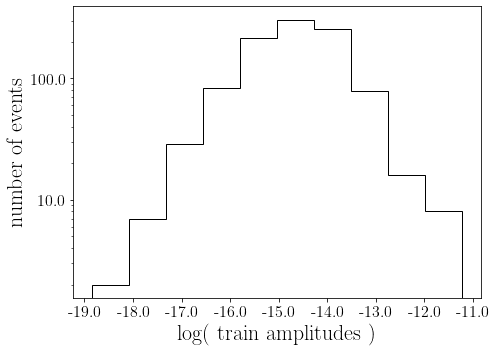

In [19]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.hist( trn_ampl, histtype='stepfilled', fill=None )

axs.set_yscale( 'log' )

axs.set_xlabel( "log( train amplitudes )", fontproperties=axislabelfont )
axs.set_ylabel( "number of events", fontproperties=axislabelfont )

xticks = axs.get_xticks()
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

fig.tight_layout()

## Datasets and dataloaders

First define a class for the datasets.

In [20]:
class amp_dataset( Dataset ):
    
    def __init__( self, data, amp ):
        self.data = data
        self.amp = amp

    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx], self.amp[idx]

Then initialise them with the data and amplitudes.  We use unsqueeze here so that the shape of the amplitudes matches the shape output from the neural network.

In [21]:
trn_dataset = amp_dataset( trn_datfp, trn_amplp.unsqueeze(-1) )
val_dataset = amp_dataset( val_datfp, val_amplp.unsqueeze(-1) )
tst_dataset = amp_dataset( tst_datfp, tst_amplp.unsqueeze(-1) )

Now we can define a dataloader for each of these datasets.

In [22]:
trn_dataloader = DataLoader( trn_dataset, batch_size=64, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=64, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=True )

And we can check that the shape for the kinematic data and amplitudes come out correct.

## Building the neural network

Now we build a very simple class for our neural network, which we call amp_net.

In [23]:
class amp_net( nn.Module ):
    
    # default hdn_dim is 30, but can be changed upon initialisation
    def __init__( self, hdn_dim=30 ):
        
        super( amp_net, self ).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear( ipt_dim, hdn_dim ),
            nn.ReLU(),
            nn.Linear( hdn_dim, hdn_dim ),
            nn.ReLU(),
            nn.Linear( hdn_dim, hdn_dim ),
            nn.ReLU(),
            nn.Linear( hdn_dim, hdn_dim ),
            nn.ReLU(),
            nn.Linear( hdn_dim, opt_dim ),
        )

    def forward( self, x ):
        out = self.linear_relu_stack( x )
        return out

Check if we have a GPU.

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Optimising (training) the neural network

We need to decide what function we want the neural network to optimise, i.e. the loss function.  There are a number of choices to decide from, the key point is that the loss function should be minimised when the neural network correctly predicts the amplitude given the kinematical information on the event.  For this we'll use the MSE, the mean squared error.

$\text{MSE} = ( \text{pred_amp} - \text{true_amp} )^2 $

In [25]:
loss_fn = nn.MSELoss()

PyTorch will compute gradients of this loss function with respect to the trainable parameters of the network.  The network is optimised by updating the parameters using the gradients.  The exact scheme to do this is defined by our choice of optimiser.  A standard choice is the Adam optimiser, which we will use here with it's default hyper-parameters.

You can read more about this optimiser here:
 - https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
 - https://arxiv.org/abs/1412.6980

We've already set the batch size when defining the dataloaders.  Below we set the number of epochs, i.e. the number of times we will iterate through the training data to optimise the network.  This means that the total number of updates to the network parameters will be $\simeq\text{size of dataset}\times \text{epochs} / \text{batch size}$.

Now we can write a training loop for a single epoch.

In [26]:
def train_epoch( dataloader, model, loss_fn, optimizer ):
    
    size = len( dataloader.dataset )
    
    for batch, (X, y) in enumerate(dataloader):

        # pass data through network
        pred = model(X)
        
        # compute loss
        loss = loss_fn( pred, y )

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print( f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]" )

To monitor the performance of the network on the regression task we want to calculate the loss of both the training data and the validation data on the same network, so we have the following functions:

In [27]:
def val_pass( dataloader, model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    vl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X )
            vl += loss_fn( pred, y ).item()

    vl /= num_batches
    print( f"avg val loss per batch: {vl:>8f}" )
    
    return vl

def trn_pass( dataloader, model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    tl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X )
            tl += loss_fn( pred, y ).item()

    tl /= num_batches
    print( f"avg trn loss per batch: {tl:>8f}" )
    
    return tl

Now we can train the model!

In [29]:
# a useful function to present things clearer
def seperator():
    print( "-----------------------------------------------" )

# define parameters
ipt_dim = 20
opt_dim = 1
hdn_dim = 50
batch_size = 64
trn_dataloader = DataLoader( trn_dataset, batch_size=batch_size, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=batch_size, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=batch_size, shuffle=True )
epochs = 1500

# re-initialise the model and the optimizer
hdn_dim = 50
model = amp_net( hdn_dim=hdn_dim ).to(device)
learning_rate = 5e-4
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
seperator()
print( "model architecture ")
seperator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    seperator()
    print( f"Epoch {t+1}" )
    seperator()
    train_epoch( trn_dataloader, model, loss_fn, optimizer )
    seperator()
    trn_loss = trn_pass( trn_dataloader, model, loss_fn )
    trn_losses.append( trn_loss )
    seperator()
    val_loss = val_pass( val_dataloader, model, loss_fn )
    val_losses.append( val_loss )
    seperator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 215.065033  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 208.479194
-----------------------------------------------
avg val loss per batch: 210.141555
-----------------------------------------------
|
-----------------------------------------------
Epoch 2
-----------------------------------------------
c

avg val loss per batch: 5.572081
-----------------------------------------------
|
-----------------------------------------------
Epoch 23
-----------------------------------------------
current batch loss: 4.134043  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 3.339883
-----------------------------------------------
avg val loss per batch: 4.126253
-----------------------------------------------
|
-----------------------------------------------
Epoch 24
-----------------------------------------------
current batch loss: 3.468022  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 2.414808
-----------------------------------------------
avg val loss per batch: 3.050161
-----------------------------------------------
|
-----------------------------------------------
Epoch 25
-----------------------------------------------
current batch loss: 3.157486  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.546458
-----------------------------------------------
|
-----------------------------------------------
Epoch 46
-----------------------------------------------
current batch loss: 0.505102  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.418395
-----------------------------------------------
avg val loss per batch: 0.530102
-----------------------------------------------
|
-----------------------------------------------
Epoch 47
-----------------------------------------------
current batch loss: 0.282940  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.421608
-----------------------------------------------
avg val loss per batch: 0.541541
-----------------------------------------------
|
-----------------------------------------------
Epoch 48
-----------------------------------------------
current batch loss: 0.537225  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.416972
-----------------------------------------------
|
-----------------------------------------------
Epoch 69
-----------------------------------------------
current batch loss: 0.259174  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.330159
-----------------------------------------------
avg val loss per batch: 0.446275
-----------------------------------------------
|
-----------------------------------------------
Epoch 70
-----------------------------------------------
current batch loss: 0.274658  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.311034
-----------------------------------------------
avg val loss per batch: 0.410651
-----------------------------------------------
|
-----------------------------------------------
Epoch 71
-----------------------------------------------
current batch loss: 0.288394  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.352059
-----------------------------------------------
|
-----------------------------------------------
Epoch 92
-----------------------------------------------
current batch loss: 0.176816  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.252500
-----------------------------------------------
avg val loss per batch: 0.359603
-----------------------------------------------
|
-----------------------------------------------
Epoch 93
-----------------------------------------------
current batch loss: 0.325220  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.235016
-----------------------------------------------
avg val loss per batch: 0.349401
-----------------------------------------------
|
-----------------------------------------------
Epoch 94
-----------------------------------------------
current batch loss: 0.248692  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.322050
-----------------------------------------------
|
-----------------------------------------------
Epoch 115
-----------------------------------------------
current batch loss: 0.189506  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.188768
-----------------------------------------------
avg val loss per batch: 0.319342
-----------------------------------------------
|
-----------------------------------------------
Epoch 116
-----------------------------------------------
current batch loss: 0.183905  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.198959
-----------------------------------------------
avg val loss per batch: 0.312040
-----------------------------------------------
|
-----------------------------------------------
Epoch 117
-----------------------------------------------
current batch loss: 0.182217  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.281269
-----------------------------------------------
|
-----------------------------------------------
Epoch 138
-----------------------------------------------
current batch loss: 0.124575  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.168183
-----------------------------------------------
avg val loss per batch: 0.287750
-----------------------------------------------
|
-----------------------------------------------
Epoch 139
-----------------------------------------------
current batch loss: 0.153616  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.155179
-----------------------------------------------
avg val loss per batch: 0.292948
-----------------------------------------------
|
-----------------------------------------------
Epoch 140
-----------------------------------------------
current batch loss: 0.124754  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.276924
-----------------------------------------------
|
-----------------------------------------------
Epoch 161
-----------------------------------------------
current batch loss: 0.155538  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.139083
-----------------------------------------------
avg val loss per batch: 0.274189
-----------------------------------------------
|
-----------------------------------------------
Epoch 162
-----------------------------------------------
current batch loss: 0.120221  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.136509
-----------------------------------------------
avg val loss per batch: 0.267782
-----------------------------------------------
|
-----------------------------------------------
Epoch 163
-----------------------------------------------
current batch loss: 0.080712  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.236016
-----------------------------------------------
|
-----------------------------------------------
Epoch 184
-----------------------------------------------
current batch loss: 0.167009  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.112247
-----------------------------------------------
avg val loss per batch: 0.238049
-----------------------------------------------
|
-----------------------------------------------
Epoch 185
-----------------------------------------------
current batch loss: 0.119344  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.114443
-----------------------------------------------
avg val loss per batch: 0.244076
-----------------------------------------------
|
-----------------------------------------------
Epoch 186
-----------------------------------------------
current batch loss: 0.110970  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.232244
-----------------------------------------------
|
-----------------------------------------------
Epoch 207
-----------------------------------------------
current batch loss: 0.100939  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.106402
-----------------------------------------------
avg val loss per batch: 0.231791
-----------------------------------------------
|
-----------------------------------------------
Epoch 208
-----------------------------------------------
current batch loss: 0.100042  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.098608
-----------------------------------------------
avg val loss per batch: 0.224055
-----------------------------------------------
|
-----------------------------------------------
Epoch 209
-----------------------------------------------
current batch loss: 0.106490  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.221830
-----------------------------------------------
|
-----------------------------------------------
Epoch 230
-----------------------------------------------
current batch loss: 0.139317  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.089507
-----------------------------------------------
avg val loss per batch: 0.222731
-----------------------------------------------
|
-----------------------------------------------
Epoch 231
-----------------------------------------------
current batch loss: 0.112435  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.095454
-----------------------------------------------
avg val loss per batch: 0.240845
-----------------------------------------------
|
-----------------------------------------------
Epoch 232
-----------------------------------------------
current batch loss: 0.057211  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.216454
-----------------------------------------------
|
-----------------------------------------------
Epoch 253
-----------------------------------------------
current batch loss: 0.075618  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.084118
-----------------------------------------------
avg val loss per batch: 0.217524
-----------------------------------------------
|
-----------------------------------------------
Epoch 254
-----------------------------------------------
current batch loss: 0.071658  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.089728
-----------------------------------------------
avg val loss per batch: 0.230852
-----------------------------------------------
|
-----------------------------------------------
Epoch 255
-----------------------------------------------
current batch loss: 0.104340  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.212427
-----------------------------------------------
|
-----------------------------------------------
Epoch 276
-----------------------------------------------
current batch loss: 0.084125  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.073957
-----------------------------------------------
avg val loss per batch: 0.223009
-----------------------------------------------
|
-----------------------------------------------
Epoch 277
-----------------------------------------------
current batch loss: 0.060414  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.074901
-----------------------------------------------
avg val loss per batch: 0.208644
-----------------------------------------------
|
-----------------------------------------------
Epoch 278
-----------------------------------------------
current batch loss: 0.088207  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.215203
-----------------------------------------------
|
-----------------------------------------------
Epoch 299
-----------------------------------------------
current batch loss: 0.074280  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.067086
-----------------------------------------------
avg val loss per batch: 0.212708
-----------------------------------------------
|
-----------------------------------------------
Epoch 300
-----------------------------------------------
current batch loss: 0.050718  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.078474
-----------------------------------------------
avg val loss per batch: 0.219722
-----------------------------------------------
|
-----------------------------------------------
Epoch 301
-----------------------------------------------
current batch loss: 0.130244  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.205482
-----------------------------------------------
|
-----------------------------------------------
Epoch 322
-----------------------------------------------
current batch loss: 0.057623  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.073417
-----------------------------------------------
avg val loss per batch: 0.229342
-----------------------------------------------
|
-----------------------------------------------
Epoch 323
-----------------------------------------------
current batch loss: 0.064016  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.068750
-----------------------------------------------
avg val loss per batch: 0.210026
-----------------------------------------------
|
-----------------------------------------------
Epoch 324
-----------------------------------------------
current batch loss: 0.071009  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.216584
-----------------------------------------------
|
-----------------------------------------------
Epoch 345
-----------------------------------------------
current batch loss: 0.046241  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.059108
-----------------------------------------------
avg val loss per batch: 0.206960
-----------------------------------------------
|
-----------------------------------------------
Epoch 346
-----------------------------------------------
current batch loss: 0.062152  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.060037
-----------------------------------------------
avg val loss per batch: 0.205326
-----------------------------------------------
|
-----------------------------------------------
Epoch 347
-----------------------------------------------
current batch loss: 0.051300  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.211611
-----------------------------------------------
|
-----------------------------------------------
Epoch 368
-----------------------------------------------
current batch loss: 0.095634  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.066439
-----------------------------------------------
avg val loss per batch: 0.202322
-----------------------------------------------
|
-----------------------------------------------
Epoch 369
-----------------------------------------------
current batch loss: 0.072765  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.055610
-----------------------------------------------
avg val loss per batch: 0.214271
-----------------------------------------------
|
-----------------------------------------------
Epoch 370
-----------------------------------------------
current batch loss: 0.046300  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.200714
-----------------------------------------------
|
-----------------------------------------------
Epoch 391
-----------------------------------------------
current batch loss: 0.048130  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.052817
-----------------------------------------------
avg val loss per batch: 0.201093
-----------------------------------------------
|
-----------------------------------------------
Epoch 392
-----------------------------------------------
current batch loss: 0.054008  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.053997
-----------------------------------------------
avg val loss per batch: 0.221669
-----------------------------------------------
|
-----------------------------------------------
Epoch 393
-----------------------------------------------
current batch loss: 0.065253  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.207880
-----------------------------------------------
|
-----------------------------------------------
Epoch 414
-----------------------------------------------
current batch loss: 0.043494  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.058608
-----------------------------------------------
avg val loss per batch: 0.201905
-----------------------------------------------
|
-----------------------------------------------
Epoch 415
-----------------------------------------------
current batch loss: 0.053795  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.063984
-----------------------------------------------
avg val loss per batch: 0.230938
-----------------------------------------------
|
-----------------------------------------------
Epoch 416
-----------------------------------------------
current batch loss: 0.051944  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.210832
-----------------------------------------------
|
-----------------------------------------------
Epoch 437
-----------------------------------------------
current batch loss: 0.046512  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.046042
-----------------------------------------------
avg val loss per batch: 0.205645
-----------------------------------------------
|
-----------------------------------------------
Epoch 438
-----------------------------------------------
current batch loss: 0.044142  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.063182
-----------------------------------------------
avg val loss per batch: 0.238812
-----------------------------------------------
|
-----------------------------------------------
Epoch 439
-----------------------------------------------
current batch loss: 0.074117  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.205104
-----------------------------------------------
|
-----------------------------------------------
Epoch 460
-----------------------------------------------
current batch loss: 0.062141  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.056860
-----------------------------------------------
avg val loss per batch: 0.209943
-----------------------------------------------
|
-----------------------------------------------
Epoch 461
-----------------------------------------------
current batch loss: 0.056915  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.046315
-----------------------------------------------
avg val loss per batch: 0.200027
-----------------------------------------------
|
-----------------------------------------------
Epoch 462
-----------------------------------------------
current batch loss: 0.059356  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.202502
-----------------------------------------------
|
-----------------------------------------------
Epoch 483
-----------------------------------------------
current batch loss: 0.040454  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.051975
-----------------------------------------------
avg val loss per batch: 0.204226
-----------------------------------------------
|
-----------------------------------------------
Epoch 484
-----------------------------------------------
current batch loss: 0.043757  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.044791
-----------------------------------------------
avg val loss per batch: 0.217249
-----------------------------------------------
|
-----------------------------------------------
Epoch 485
-----------------------------------------------
current batch loss: 0.036820  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.202383
-----------------------------------------------
|
-----------------------------------------------
Epoch 506
-----------------------------------------------
current batch loss: 0.040679  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.070884
-----------------------------------------------
avg val loss per batch: 0.238353
-----------------------------------------------
|
-----------------------------------------------
Epoch 507
-----------------------------------------------
current batch loss: 0.080979  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.041571
-----------------------------------------------
avg val loss per batch: 0.203772
-----------------------------------------------
|
-----------------------------------------------
Epoch 508
-----------------------------------------------
current batch loss: 0.020927  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.228455
-----------------------------------------------
|
-----------------------------------------------
Epoch 529
-----------------------------------------------
current batch loss: 0.052141  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.042176
-----------------------------------------------
avg val loss per batch: 0.207114
-----------------------------------------------
|
-----------------------------------------------
Epoch 530
-----------------------------------------------
current batch loss: 0.035047  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.040904
-----------------------------------------------
avg val loss per batch: 0.207544
-----------------------------------------------
|
-----------------------------------------------
Epoch 531
-----------------------------------------------
current batch loss: 0.038534  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.241249
-----------------------------------------------
|
-----------------------------------------------
Epoch 552
-----------------------------------------------
current batch loss: 0.045130  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.037915
-----------------------------------------------
avg val loss per batch: 0.198756
-----------------------------------------------
|
-----------------------------------------------
Epoch 553
-----------------------------------------------
current batch loss: 0.042134  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.038849
-----------------------------------------------
avg val loss per batch: 0.197807
-----------------------------------------------
|
-----------------------------------------------
Epoch 554
-----------------------------------------------
current batch loss: 0.039960  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.200319
-----------------------------------------------
|
-----------------------------------------------
Epoch 575
-----------------------------------------------
current batch loss: 0.026962  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.046128
-----------------------------------------------
avg val loss per batch: 0.214032
-----------------------------------------------
|
-----------------------------------------------
Epoch 576
-----------------------------------------------
current batch loss: 0.051271  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.043652
-----------------------------------------------
avg val loss per batch: 0.225792
-----------------------------------------------
|
-----------------------------------------------
Epoch 577
-----------------------------------------------
current batch loss: 0.048043  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.211433
-----------------------------------------------
|
-----------------------------------------------
Epoch 598
-----------------------------------------------
current batch loss: 0.051068  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.043860
-----------------------------------------------
avg val loss per batch: 0.209058
-----------------------------------------------
|
-----------------------------------------------
Epoch 599
-----------------------------------------------
current batch loss: 0.060218  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.036797
-----------------------------------------------
avg val loss per batch: 0.210108
-----------------------------------------------
|
-----------------------------------------------
Epoch 600
-----------------------------------------------
current batch loss: 0.032234  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.209894
-----------------------------------------------
|
-----------------------------------------------
Epoch 621
-----------------------------------------------
current batch loss: 0.040860  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.048848
-----------------------------------------------
avg val loss per batch: 0.202043
-----------------------------------------------
|
-----------------------------------------------
Epoch 622
-----------------------------------------------
current batch loss: 0.055205  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.037377
-----------------------------------------------
avg val loss per batch: 0.211976
-----------------------------------------------
|
-----------------------------------------------
Epoch 623
-----------------------------------------------
current batch loss: 0.045689  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.201421
-----------------------------------------------
|
-----------------------------------------------
Epoch 644
-----------------------------------------------
current batch loss: 0.047750  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.032219
-----------------------------------------------
avg val loss per batch: 0.202369
-----------------------------------------------
|
-----------------------------------------------
Epoch 645
-----------------------------------------------
current batch loss: 0.037875  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.033330
-----------------------------------------------
avg val loss per batch: 0.200824
-----------------------------------------------
|
-----------------------------------------------
Epoch 646
-----------------------------------------------
current batch loss: 0.030671  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.241492
-----------------------------------------------
|
-----------------------------------------------
Epoch 667
-----------------------------------------------
current batch loss: 0.048445  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.049983
-----------------------------------------------
avg val loss per batch: 0.196115
-----------------------------------------------
|
-----------------------------------------------
Epoch 668
-----------------------------------------------
current batch loss: 0.044662  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.035454
-----------------------------------------------
avg val loss per batch: 0.192336
-----------------------------------------------
|
-----------------------------------------------
Epoch 669
-----------------------------------------------
current batch loss: 0.043534  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.193797
-----------------------------------------------
|
-----------------------------------------------
Epoch 690
-----------------------------------------------
current batch loss: 0.030081  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.038415
-----------------------------------------------
avg val loss per batch: 0.194005
-----------------------------------------------
|
-----------------------------------------------
Epoch 691
-----------------------------------------------
current batch loss: 0.048717  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.045851
-----------------------------------------------
avg val loss per batch: 0.203110
-----------------------------------------------
|
-----------------------------------------------
Epoch 692
-----------------------------------------------
current batch loss: 0.050331  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.203656
-----------------------------------------------
|
-----------------------------------------------
Epoch 713
-----------------------------------------------
current batch loss: 0.048494  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.030311
-----------------------------------------------
avg val loss per batch: 0.201517
-----------------------------------------------
|
-----------------------------------------------
Epoch 714
-----------------------------------------------
current batch loss: 0.041315  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.031305
-----------------------------------------------
avg val loss per batch: 0.208704
-----------------------------------------------
|
-----------------------------------------------
Epoch 715
-----------------------------------------------
current batch loss: 0.032829  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.204295
-----------------------------------------------
|
-----------------------------------------------
Epoch 736
-----------------------------------------------
current batch loss: 0.043480  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.030671
-----------------------------------------------
avg val loss per batch: 0.203355
-----------------------------------------------
|
-----------------------------------------------
Epoch 737
-----------------------------------------------
current batch loss: 0.039225  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.028558
-----------------------------------------------
avg val loss per batch: 0.205474
-----------------------------------------------
|
-----------------------------------------------
Epoch 738
-----------------------------------------------
current batch loss: 0.020117  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.213620
-----------------------------------------------
|
-----------------------------------------------
Epoch 759
-----------------------------------------------
current batch loss: 0.019133  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.030503
-----------------------------------------------
avg val loss per batch: 0.208298
-----------------------------------------------
|
-----------------------------------------------
Epoch 760
-----------------------------------------------
current batch loss: 0.032330  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.029780
-----------------------------------------------
avg val loss per batch: 0.202823
-----------------------------------------------
|
-----------------------------------------------
Epoch 761
-----------------------------------------------
current batch loss: 0.021670  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.204441
-----------------------------------------------
|
-----------------------------------------------
Epoch 782
-----------------------------------------------
current batch loss: 0.028183  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.032343
-----------------------------------------------
avg val loss per batch: 0.208068
-----------------------------------------------
|
-----------------------------------------------
Epoch 783
-----------------------------------------------
current batch loss: 0.026520  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.031662
-----------------------------------------------
avg val loss per batch: 0.208816
-----------------------------------------------
|
-----------------------------------------------
Epoch 784
-----------------------------------------------
current batch loss: 0.031286  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.213796
-----------------------------------------------
|
-----------------------------------------------
Epoch 805
-----------------------------------------------
current batch loss: 0.027832  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.034740
-----------------------------------------------
avg val loss per batch: 0.196361
-----------------------------------------------
|
-----------------------------------------------
Epoch 806
-----------------------------------------------
current batch loss: 0.029535  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.030135
-----------------------------------------------
avg val loss per batch: 0.201212
-----------------------------------------------
|
-----------------------------------------------
Epoch 807
-----------------------------------------------
current batch loss: 0.049655  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.199815
-----------------------------------------------
|
-----------------------------------------------
Epoch 828
-----------------------------------------------
current batch loss: 0.028721  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.026718
-----------------------------------------------
avg val loss per batch: 0.196538
-----------------------------------------------
|
-----------------------------------------------
Epoch 829
-----------------------------------------------
current batch loss: 0.028689  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.033813
-----------------------------------------------
avg val loss per batch: 0.193573
-----------------------------------------------
|
-----------------------------------------------
Epoch 830
-----------------------------------------------
current batch loss: 0.031485  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.193289
-----------------------------------------------
|
-----------------------------------------------
Epoch 851
-----------------------------------------------
current batch loss: 0.028171  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.028066
-----------------------------------------------
avg val loss per batch: 0.189131
-----------------------------------------------
|
-----------------------------------------------
Epoch 852
-----------------------------------------------
current batch loss: 0.022313  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.025601
-----------------------------------------------
avg val loss per batch: 0.196565
-----------------------------------------------
|
-----------------------------------------------
Epoch 853
-----------------------------------------------
current batch loss: 0.022880  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.206037
-----------------------------------------------
|
-----------------------------------------------
Epoch 874
-----------------------------------------------
current batch loss: 0.043583  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.033054
-----------------------------------------------
avg val loss per batch: 0.214068
-----------------------------------------------
|
-----------------------------------------------
Epoch 875
-----------------------------------------------
current batch loss: 0.023453  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.032751
-----------------------------------------------
avg val loss per batch: 0.205909
-----------------------------------------------
|
-----------------------------------------------
Epoch 876
-----------------------------------------------
current batch loss: 0.036092  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.206927
-----------------------------------------------
|
-----------------------------------------------
Epoch 897
-----------------------------------------------
current batch loss: 0.044664  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.028246
-----------------------------------------------
avg val loss per batch: 0.202492
-----------------------------------------------
|
-----------------------------------------------
Epoch 898
-----------------------------------------------
current batch loss: 0.025202  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.030983
-----------------------------------------------
avg val loss per batch: 0.209680
-----------------------------------------------
|
-----------------------------------------------
Epoch 899
-----------------------------------------------
current batch loss: 0.023606  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.203541
-----------------------------------------------
|
-----------------------------------------------
Epoch 920
-----------------------------------------------
current batch loss: 0.024378  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.026267
-----------------------------------------------
avg val loss per batch: 0.199795
-----------------------------------------------
|
-----------------------------------------------
Epoch 921
-----------------------------------------------
current batch loss: 0.018647  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.034211
-----------------------------------------------
avg val loss per batch: 0.196328
-----------------------------------------------
|
-----------------------------------------------
Epoch 922
-----------------------------------------------
current batch loss: 0.025039  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.204127
-----------------------------------------------
|
-----------------------------------------------
Epoch 943
-----------------------------------------------
current batch loss: 0.031253  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.041518
-----------------------------------------------
avg val loss per batch: 0.228429
-----------------------------------------------
|
-----------------------------------------------
Epoch 944
-----------------------------------------------
current batch loss: 0.032362  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.040188
-----------------------------------------------
avg val loss per batch: 0.216184
-----------------------------------------------
|
-----------------------------------------------
Epoch 945
-----------------------------------------------
current batch loss: 0.031291  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.196329
-----------------------------------------------
|
-----------------------------------------------
Epoch 966
-----------------------------------------------
current batch loss: 0.025043  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.024717
-----------------------------------------------
avg val loss per batch: 0.200929
-----------------------------------------------
|
-----------------------------------------------
Epoch 967
-----------------------------------------------
current batch loss: 0.021132  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.031693
-----------------------------------------------
avg val loss per batch: 0.201275
-----------------------------------------------
|
-----------------------------------------------
Epoch 968
-----------------------------------------------
current batch loss: 0.020642  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.202971
-----------------------------------------------
|
-----------------------------------------------
Epoch 989
-----------------------------------------------
current batch loss: 0.029549  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.051796
-----------------------------------------------
avg val loss per batch: 0.238844
-----------------------------------------------
|
-----------------------------------------------
Epoch 990
-----------------------------------------------
current batch loss: 0.054480  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.044255
-----------------------------------------------
avg val loss per batch: 0.223163
-----------------------------------------------
|
-----------------------------------------------
Epoch 991
-----------------------------------------------
current batch loss: 0.049398  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.219488
-----------------------------------------------
|
-----------------------------------------------
Epoch 1012
-----------------------------------------------
current batch loss: 0.025360  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.032846
-----------------------------------------------
avg val loss per batch: 0.224862
-----------------------------------------------
|
-----------------------------------------------
Epoch 1013
-----------------------------------------------
current batch loss: 0.042702  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.024912
-----------------------------------------------
avg val loss per batch: 0.207531
-----------------------------------------------
|
-----------------------------------------------
Epoch 1014
-----------------------------------------------
current batch loss: 0.025216  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.201153
-----------------------------------------------
|
-----------------------------------------------
Epoch 1035
-----------------------------------------------
current batch loss: 0.038941  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.028533
-----------------------------------------------
avg val loss per batch: 0.198822
-----------------------------------------------
|
-----------------------------------------------
Epoch 1036
-----------------------------------------------
current batch loss: 0.045574  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.025955
-----------------------------------------------
avg val loss per batch: 0.201773
-----------------------------------------------
|
-----------------------------------------------
Epoch 1037
-----------------------------------------------
current batch loss: 0.028745  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.195448
-----------------------------------------------
|
-----------------------------------------------
Epoch 1058
-----------------------------------------------
current batch loss: 0.024203  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.028109
-----------------------------------------------
avg val loss per batch: 0.210511
-----------------------------------------------
|
-----------------------------------------------
Epoch 1059
-----------------------------------------------
current batch loss: 0.033407  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.023276
-----------------------------------------------
avg val loss per batch: 0.198937
-----------------------------------------------
|
-----------------------------------------------
Epoch 1060
-----------------------------------------------
current batch loss: 0.025839  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.215470
-----------------------------------------------
|
-----------------------------------------------
Epoch 1081
-----------------------------------------------
current batch loss: 0.024957  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.092594
-----------------------------------------------
avg val loss per batch: 0.323648
-----------------------------------------------
|
-----------------------------------------------
Epoch 1082
-----------------------------------------------
current batch loss: 0.096524  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.030341
-----------------------------------------------
avg val loss per batch: 0.218676
-----------------------------------------------
|
-----------------------------------------------
Epoch 1083
-----------------------------------------------
current batch loss: 0.028899  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.231167
-----------------------------------------------
|
-----------------------------------------------
Epoch 1104
-----------------------------------------------
current batch loss: 0.037629  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.025113
-----------------------------------------------
avg val loss per batch: 0.205883
-----------------------------------------------
|
-----------------------------------------------
Epoch 1105
-----------------------------------------------
current batch loss: 0.035031  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.029961
-----------------------------------------------
avg val loss per batch: 0.219208
-----------------------------------------------
|
-----------------------------------------------
Epoch 1106
-----------------------------------------------
current batch loss: 0.022543  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.218188
-----------------------------------------------
|
-----------------------------------------------
Epoch 1127
-----------------------------------------------
current batch loss: 0.026573  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.022850
-----------------------------------------------
avg val loss per batch: 0.200847
-----------------------------------------------
|
-----------------------------------------------
Epoch 1128
-----------------------------------------------
current batch loss: 0.020115  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.023483
-----------------------------------------------
avg val loss per batch: 0.204389
-----------------------------------------------
|
-----------------------------------------------
Epoch 1129
-----------------------------------------------
current batch loss: 0.025236  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.210646
-----------------------------------------------
|
-----------------------------------------------
Epoch 1150
-----------------------------------------------
current batch loss: 0.021277  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.024364
-----------------------------------------------
avg val loss per batch: 0.204436
-----------------------------------------------
|
-----------------------------------------------
Epoch 1151
-----------------------------------------------
current batch loss: 0.026731  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.026620
-----------------------------------------------
avg val loss per batch: 0.198659
-----------------------------------------------
|
-----------------------------------------------
Epoch 1152
-----------------------------------------------
current batch loss: 0.026575  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.202223
-----------------------------------------------
|
-----------------------------------------------
Epoch 1173
-----------------------------------------------
current batch loss: 0.032313  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.025086
-----------------------------------------------
avg val loss per batch: 0.207172
-----------------------------------------------
|
-----------------------------------------------
Epoch 1174
-----------------------------------------------
current batch loss: 0.026774  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.022590
-----------------------------------------------
avg val loss per batch: 0.201651
-----------------------------------------------
|
-----------------------------------------------
Epoch 1175
-----------------------------------------------
current batch loss: 0.021967  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.197034
-----------------------------------------------
|
-----------------------------------------------
Epoch 1196
-----------------------------------------------
current batch loss: 0.023057  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.023396
-----------------------------------------------
avg val loss per batch: 0.209543
-----------------------------------------------
|
-----------------------------------------------
Epoch 1197
-----------------------------------------------
current batch loss: 0.023074  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.026564
-----------------------------------------------
avg val loss per batch: 0.195580
-----------------------------------------------
|
-----------------------------------------------
Epoch 1198
-----------------------------------------------
current batch loss: 0.041036  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.206541
-----------------------------------------------
|
-----------------------------------------------
Epoch 1219
-----------------------------------------------
current batch loss: 0.020366  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.024323
-----------------------------------------------
avg val loss per batch: 0.209372
-----------------------------------------------
|
-----------------------------------------------
Epoch 1220
-----------------------------------------------
current batch loss: 0.019555  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.023549
-----------------------------------------------
avg val loss per batch: 0.208988
-----------------------------------------------
|
-----------------------------------------------
Epoch 1221
-----------------------------------------------
current batch loss: 0.032395  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.197575
-----------------------------------------------
|
-----------------------------------------------
Epoch 1242
-----------------------------------------------
current batch loss: 0.023109  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.021182
-----------------------------------------------
avg val loss per batch: 0.199709
-----------------------------------------------
|
-----------------------------------------------
Epoch 1243
-----------------------------------------------
current batch loss: 0.020834  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.022197
-----------------------------------------------
avg val loss per batch: 0.206693
-----------------------------------------------
|
-----------------------------------------------
Epoch 1244
-----------------------------------------------
current batch loss: 0.028033  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.207813
-----------------------------------------------
|
-----------------------------------------------
Epoch 1265
-----------------------------------------------
current batch loss: 0.022870  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.021112
-----------------------------------------------
avg val loss per batch: 0.195934
-----------------------------------------------
|
-----------------------------------------------
Epoch 1266
-----------------------------------------------
current batch loss: 0.017722  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.023382
-----------------------------------------------
avg val loss per batch: 0.196244
-----------------------------------------------
|
-----------------------------------------------
Epoch 1267
-----------------------------------------------
current batch loss: 0.020759  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.198349
-----------------------------------------------
|
-----------------------------------------------
Epoch 1288
-----------------------------------------------
current batch loss: 0.014940  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.022333
-----------------------------------------------
avg val loss per batch: 0.205916
-----------------------------------------------
|
-----------------------------------------------
Epoch 1289
-----------------------------------------------
current batch loss: 0.018846  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.024444
-----------------------------------------------
avg val loss per batch: 0.198721
-----------------------------------------------
|
-----------------------------------------------
Epoch 1290
-----------------------------------------------
current batch loss: 0.025122  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.226243
-----------------------------------------------
|
-----------------------------------------------
Epoch 1311
-----------------------------------------------
current batch loss: 0.028092  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.021750
-----------------------------------------------
avg val loss per batch: 0.203942
-----------------------------------------------
|
-----------------------------------------------
Epoch 1312
-----------------------------------------------
current batch loss: 0.021248  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.022202
-----------------------------------------------
avg val loss per batch: 0.203274
-----------------------------------------------
|
-----------------------------------------------
Epoch 1313
-----------------------------------------------
current batch loss: 0.026339  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.197775
-----------------------------------------------
|
-----------------------------------------------
Epoch 1334
-----------------------------------------------
current batch loss: 0.029238  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.025838
-----------------------------------------------
avg val loss per batch: 0.199372
-----------------------------------------------
|
-----------------------------------------------
Epoch 1335
-----------------------------------------------
current batch loss: 0.031228  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.033904
-----------------------------------------------
avg val loss per batch: 0.197942
-----------------------------------------------
|
-----------------------------------------------
Epoch 1336
-----------------------------------------------
current batch loss: 0.032152  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.218630
-----------------------------------------------
|
-----------------------------------------------
Epoch 1357
-----------------------------------------------
current batch loss: 0.063429  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.029232
-----------------------------------------------
avg val loss per batch: 0.197147
-----------------------------------------------
|
-----------------------------------------------
Epoch 1358
-----------------------------------------------
current batch loss: 0.030391  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.025366
-----------------------------------------------
avg val loss per batch: 0.196068
-----------------------------------------------
|
-----------------------------------------------
Epoch 1359
-----------------------------------------------
current batch loss: 0.023943  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.205086
-----------------------------------------------
|
-----------------------------------------------
Epoch 1380
-----------------------------------------------
current batch loss: 0.018080  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.022981
-----------------------------------------------
avg val loss per batch: 0.202031
-----------------------------------------------
|
-----------------------------------------------
Epoch 1381
-----------------------------------------------
current batch loss: 0.025138  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.023252
-----------------------------------------------
avg val loss per batch: 0.207041
-----------------------------------------------
|
-----------------------------------------------
Epoch 1382
-----------------------------------------------
current batch loss: 0.028608  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.196539
-----------------------------------------------
|
-----------------------------------------------
Epoch 1403
-----------------------------------------------
current batch loss: 0.021082  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.023487
-----------------------------------------------
avg val loss per batch: 0.210788
-----------------------------------------------
|
-----------------------------------------------
Epoch 1404
-----------------------------------------------
current batch loss: 0.020750  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.023835
-----------------------------------------------
avg val loss per batch: 0.196949
-----------------------------------------------
|
-----------------------------------------------
Epoch 1405
-----------------------------------------------
current batch loss: 0.033273  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.223087
-----------------------------------------------
|
-----------------------------------------------
Epoch 1426
-----------------------------------------------
current batch loss: 0.035895  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.033692
-----------------------------------------------
avg val loss per batch: 0.222686
-----------------------------------------------
|
-----------------------------------------------
Epoch 1427
-----------------------------------------------
current batch loss: 0.032785  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.020820
-----------------------------------------------
avg val loss per batch: 0.194229
-----------------------------------------------
|
-----------------------------------------------
Epoch 1428
-----------------------------------------------
current batch loss: 0.020209  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.199489
-----------------------------------------------
|
-----------------------------------------------
Epoch 1449
-----------------------------------------------
current batch loss: 0.017050  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.020182
-----------------------------------------------
avg val loss per batch: 0.200709
-----------------------------------------------
|
-----------------------------------------------
Epoch 1450
-----------------------------------------------
current batch loss: 0.018696  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.026862
-----------------------------------------------
avg val loss per batch: 0.202496
-----------------------------------------------
|
-----------------------------------------------
Epoch 1451
-----------------------------------------------
current batch loss: 0.027119  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.200923
-----------------------------------------------
|
-----------------------------------------------
Epoch 1472
-----------------------------------------------
current batch loss: 0.025797  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.019888
-----------------------------------------------
avg val loss per batch: 0.196116
-----------------------------------------------
|
-----------------------------------------------
Epoch 1473
-----------------------------------------------
current batch loss: 0.012992  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.020649
-----------------------------------------------
avg val loss per batch: 0.203794
-----------------------------------------------
|
-----------------------------------------------
Epoch 1474
-----------------------------------------------
current batch loss: 0.028075  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.195305
-----------------------------------------------
|
-----------------------------------------------
Epoch 1495
-----------------------------------------------
current batch loss: 0.021891  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.019761
-----------------------------------------------
avg val loss per batch: 0.190464
-----------------------------------------------
|
-----------------------------------------------
Epoch 1496
-----------------------------------------------
current batch loss: 0.015536  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.027753
-----------------------------------------------
avg val loss per batch: 0.214584
-----------------------------------------------
|
-----------------------------------------------
Epoch 1497
-----------------------------------------------
current batch loss: 0.033293  [    0/ 1000]
----------------------------------------

## Plot the train and validation losses as a function of the epochs

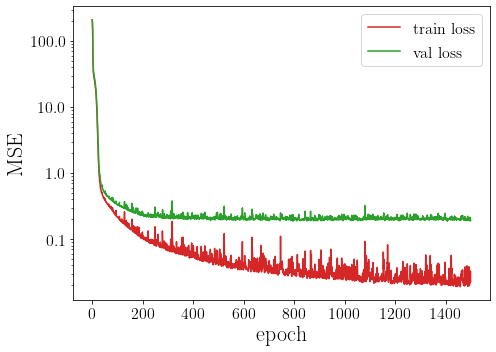

In [31]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses, label="train loss", color=c1 )
axs.plot( val_losses, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "MSE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

This is a good example of a network over-training.  At some point, the loss evaluated on the training data continues to improve, while the loss on the validation data converges to a lower limit.  In practice, it often happens that the validation loss actually gets worse when the network over-trains, so the problem can be worse than shown here.

## Network regularisation

### Dropout

Dropout is a mechanism to reduce over-fitting effects in neural network optimisation.  It was proposed in this paper (I think):

------------------

**Improving neural networks by preventing co-adaptation of feature detectors**

https://arxiv.org/abs/1207.0580

When a large feedforward neural network is trained on a small training set, it typically performs poorly on held-out test data. This "overfitting" is greatly reduced by randomly omitting half of the feature detectors on each training case. This prevents complex co-adaptations in which a feature detector is only helpful in the context of several other specific feature detectors. Instead, each neuron learns to detect a feature that is generally helpful for producing the correct answer given the combinatorially large variety of internal contexts in which it must operate. Random "dropout" gives big improvements on many benchmark tasks and sets new records for speech and object recognition. 

------------------

Dropout is implemented as a layer in pytorch.

The description given in the pytorch documentation is:

------------------

https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

During training, randomly zeroes some of the elements of the input tensor with probability $p$ using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every forward call.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons as described in the paper Improving neural networks by preventing co-adaptation of feature detectors .

Furthermore, the outputs are scaled by a factor of $\frac{1}{1-p}$ during training. This means that during evaluation the module simply computes an identity function.

------------------

So let's build the same model, but with dropout:

In [32]:
class amp_net_dr( nn.Module ):
    
    # default hdn_dim is 30, but can be changed upon initialisation
    def __init__( self, hdn_dim=30 ):
        
        super( amp_net_dr, self ).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear( ipt_dim, hdn_dim ),
            nn.Dropout( p=0.5 ),
            nn.ReLU(),
            nn.Linear( hdn_dim, hdn_dim ),
            nn.Dropout( p=0.5 ),
            nn.ReLU(),
            nn.Linear( hdn_dim, hdn_dim ),
            nn.Dropout( p=0.5 ),
            nn.ReLU(),
            nn.Linear( hdn_dim, hdn_dim ),
            nn.Dropout( p=0.5 ),
            nn.ReLU(),
            nn.Linear( hdn_dim, opt_dim ),
        )

    def forward( self, x ):
        out = self.linear_relu_stack( x )
        return out

When re-training the model we need to be careful.  When we evaluate the network on data to monitor performance, we don't want dropout to affect the results.  To do this we need to temporarily switch the model from `train` mode to `eval` mode.

In [34]:
# a useful function to present things clearer
def seperator():
    print( "-----------------------------------------------" )

# define parameters
ipt_dim = 20
opt_dim = 1
hdn_dim = 50
batch_size = 64
trn_dataloader = DataLoader( trn_dataset, batch_size=batch_size, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=batch_size, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=batch_size, shuffle=True )
epochs = 1500

# re-initialise the model and the optimizer
hdn_dim = 50
model_dr = amp_net_dr( hdn_dim=hdn_dim ).to(device)
learning_rate = 5e-4
optimizer = torch.optim.Adam( model_dr.parameters(), lr=learning_rate )
seperator()
print( "model architecture ")
seperator()
print( model_dr )

# track train and val losses
trn_losses_dr = []
val_losses_dr = []

for t in range(epochs):
    seperator()
    print( f"Epoch {t+1}" )
    seperator()
    train_epoch( trn_dataloader, model_dr, loss_fn, optimizer )
    seperator()
    model_dr.eval()
    trn_loss = trn_pass( trn_dataloader, model_dr, loss_fn )
    trn_losses_dr.append( trn_loss )
    seperator()
    val_loss = val_pass( val_dataloader, model_dr, loss_fn )
    val_losses_dr.append( val_loss )
    model_dr.train()
    seperator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
amp_net_dr(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=50, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=50, out_features=50, bias=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=1, bias=True)
  )
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 210.836075  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 204.863197
-----------------------------------------------
avg val loss per batch: 206.

avg val loss per batch: 15.968328
-----------------------------------------------
|
-----------------------------------------------
Epoch 22
-----------------------------------------------
current batch loss: 20.038454  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 12.504936
-----------------------------------------------
avg val loss per batch: 12.934900
-----------------------------------------------
|
-----------------------------------------------
Epoch 23
-----------------------------------------------
current batch loss: 21.343243  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 12.166452
-----------------------------------------------
avg val loss per batch: 12.435932
-----------------------------------------------
|
-----------------------------------------------
Epoch 24
-----------------------------------------------
current batch loss: 23.520069  [    0/ 1000]
--------------------------------------

avg val loss per batch: 3.711610
-----------------------------------------------
|
-----------------------------------------------
Epoch 45
-----------------------------------------------
current batch loss: 17.271776  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 2.769495
-----------------------------------------------
avg val loss per batch: 2.828431
-----------------------------------------------
|
-----------------------------------------------
Epoch 46
-----------------------------------------------
current batch loss: 19.978985  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 2.966335
-----------------------------------------------
avg val loss per batch: 3.001284
-----------------------------------------------
|
-----------------------------------------------
Epoch 47
-----------------------------------------------
current batch loss: 15.387792  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 2.223025
-----------------------------------------------
|
-----------------------------------------------
Epoch 68
-----------------------------------------------
current batch loss: 16.461370  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 2.249730
-----------------------------------------------
avg val loss per batch: 2.311154
-----------------------------------------------
|
-----------------------------------------------
Epoch 69
-----------------------------------------------
current batch loss: 15.054410  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.800264
-----------------------------------------------
avg val loss per batch: 1.851442
-----------------------------------------------
|
-----------------------------------------------
Epoch 70
-----------------------------------------------
current batch loss: 11.319855  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 2.220211
-----------------------------------------------
|
-----------------------------------------------
Epoch 91
-----------------------------------------------
current batch loss: 8.197219  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.820463
-----------------------------------------------
avg val loss per batch: 1.931822
-----------------------------------------------
|
-----------------------------------------------
Epoch 92
-----------------------------------------------
current batch loss: 8.139290  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.473888
-----------------------------------------------
avg val loss per batch: 1.562934
-----------------------------------------------
|
-----------------------------------------------
Epoch 93
-----------------------------------------------
current batch loss: 7.759948  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 1.377657
-----------------------------------------------
|
-----------------------------------------------
Epoch 114
-----------------------------------------------
current batch loss: 10.030990  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.852819
-----------------------------------------------
avg val loss per batch: 1.981760
-----------------------------------------------
|
-----------------------------------------------
Epoch 115
-----------------------------------------------
current batch loss: 9.121407  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.273254
-----------------------------------------------
avg val loss per batch: 1.391747
-----------------------------------------------
|
-----------------------------------------------
Epoch 116
-----------------------------------------------
current batch loss: 7.153134  [    0/ 1000]
------------------------------------------

avg val loss per batch: 0.992021
-----------------------------------------------
|
-----------------------------------------------
Epoch 137
-----------------------------------------------
current batch loss: 9.809235  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.439551
-----------------------------------------------
avg val loss per batch: 1.575621
-----------------------------------------------
|
-----------------------------------------------
Epoch 138
-----------------------------------------------
current batch loss: 13.315798  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.159530
-----------------------------------------------
avg val loss per batch: 1.266644
-----------------------------------------------
|
-----------------------------------------------
Epoch 139
-----------------------------------------------
current batch loss: 8.934556  [    0/ 1000]
------------------------------------------

avg val loss per batch: 1.289969
-----------------------------------------------
|
-----------------------------------------------
Epoch 160
-----------------------------------------------
current batch loss: 8.547882  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.308173
-----------------------------------------------
avg val loss per batch: 1.437160
-----------------------------------------------
|
-----------------------------------------------
Epoch 161
-----------------------------------------------
current batch loss: 9.068501  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.882529
-----------------------------------------------
avg val loss per batch: 0.976736
-----------------------------------------------
|
-----------------------------------------------
Epoch 162
-----------------------------------------------
current batch loss: 8.360228  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 1.124506
-----------------------------------------------
|
-----------------------------------------------
Epoch 183
-----------------------------------------------
current batch loss: 7.032835  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.014362
-----------------------------------------------
avg val loss per batch: 1.120737
-----------------------------------------------
|
-----------------------------------------------
Epoch 184
-----------------------------------------------
current batch loss: 6.721240  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.278352
-----------------------------------------------
avg val loss per batch: 1.401188
-----------------------------------------------
|
-----------------------------------------------
Epoch 185
-----------------------------------------------
current batch loss: 10.919329  [    0/ 1000]
------------------------------------------

avg val loss per batch: 1.145343
-----------------------------------------------
|
-----------------------------------------------
Epoch 206
-----------------------------------------------
current batch loss: 8.293350  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.909751
-----------------------------------------------
avg val loss per batch: 0.995753
-----------------------------------------------
|
-----------------------------------------------
Epoch 207
-----------------------------------------------
current batch loss: 6.243382  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.278318
-----------------------------------------------
avg val loss per batch: 1.392389
-----------------------------------------------
|
-----------------------------------------------
Epoch 208
-----------------------------------------------
current batch loss: 6.241371  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.886482
-----------------------------------------------
|
-----------------------------------------------
Epoch 229
-----------------------------------------------
current batch loss: 5.987483  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.243877
-----------------------------------------------
avg val loss per batch: 1.337445
-----------------------------------------------
|
-----------------------------------------------
Epoch 230
-----------------------------------------------
current batch loss: 9.287517  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.134767
-----------------------------------------------
avg val loss per batch: 1.228063
-----------------------------------------------
|
-----------------------------------------------
Epoch 231
-----------------------------------------------
current batch loss: 6.384420  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.856559
-----------------------------------------------
|
-----------------------------------------------
Epoch 252
-----------------------------------------------
current batch loss: 5.879208  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.065532
-----------------------------------------------
avg val loss per batch: 1.155114
-----------------------------------------------
|
-----------------------------------------------
Epoch 253
-----------------------------------------------
current batch loss: 6.067883  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.989171
-----------------------------------------------
avg val loss per batch: 1.077638
-----------------------------------------------
|
-----------------------------------------------
Epoch 254
-----------------------------------------------
current batch loss: 6.278607  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.731785
-----------------------------------------------
|
-----------------------------------------------
Epoch 275
-----------------------------------------------
current batch loss: 7.274038  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.833331
-----------------------------------------------
avg val loss per batch: 0.906964
-----------------------------------------------
|
-----------------------------------------------
Epoch 276
-----------------------------------------------
current batch loss: 6.136457  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.823717
-----------------------------------------------
avg val loss per batch: 0.890100
-----------------------------------------------
|
-----------------------------------------------
Epoch 277
-----------------------------------------------
current batch loss: 6.865285  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.896533
-----------------------------------------------
|
-----------------------------------------------
Epoch 298
-----------------------------------------------
current batch loss: 5.346457  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.783117
-----------------------------------------------
avg val loss per batch: 0.852233
-----------------------------------------------
|
-----------------------------------------------
Epoch 299
-----------------------------------------------
current batch loss: 7.168697  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.841392
-----------------------------------------------
avg val loss per batch: 0.912594
-----------------------------------------------
|
-----------------------------------------------
Epoch 300
-----------------------------------------------
current batch loss: 5.484028  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.666617
-----------------------------------------------
|
-----------------------------------------------
Epoch 321
-----------------------------------------------
current batch loss: 4.452765  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.901718
-----------------------------------------------
avg val loss per batch: 0.972312
-----------------------------------------------
|
-----------------------------------------------
Epoch 322
-----------------------------------------------
current batch loss: 4.364720  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.541428
-----------------------------------------------
avg val loss per batch: 0.585654
-----------------------------------------------
|
-----------------------------------------------
Epoch 323
-----------------------------------------------
current batch loss: 5.495447  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.728550
-----------------------------------------------
|
-----------------------------------------------
Epoch 344
-----------------------------------------------
current batch loss: 4.708590  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.633349
-----------------------------------------------
avg val loss per batch: 0.682573
-----------------------------------------------
|
-----------------------------------------------
Epoch 345
-----------------------------------------------
current batch loss: 6.026072  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.699653
-----------------------------------------------
avg val loss per batch: 0.756390
-----------------------------------------------
|
-----------------------------------------------
Epoch 346
-----------------------------------------------
current batch loss: 4.202082  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.656972
-----------------------------------------------
|
-----------------------------------------------
Epoch 367
-----------------------------------------------
current batch loss: 4.137263  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.617160
-----------------------------------------------
avg val loss per batch: 0.669197
-----------------------------------------------
|
-----------------------------------------------
Epoch 368
-----------------------------------------------
current batch loss: 4.617111  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.492694
-----------------------------------------------
avg val loss per batch: 0.525932
-----------------------------------------------
|
-----------------------------------------------
Epoch 369
-----------------------------------------------
current batch loss: 4.211878  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.711439
-----------------------------------------------
|
-----------------------------------------------
Epoch 390
-----------------------------------------------
current batch loss: 5.722202  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.482462
-----------------------------------------------
avg val loss per batch: 0.537587
-----------------------------------------------
|
-----------------------------------------------
Epoch 391
-----------------------------------------------
current batch loss: 4.166425  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.488836
-----------------------------------------------
avg val loss per batch: 0.543760
-----------------------------------------------
|
-----------------------------------------------
Epoch 392
-----------------------------------------------
current batch loss: 4.022638  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.649478
-----------------------------------------------
|
-----------------------------------------------
Epoch 413
-----------------------------------------------
current batch loss: 4.794373  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.560174
-----------------------------------------------
avg val loss per batch: 0.615383
-----------------------------------------------
|
-----------------------------------------------
Epoch 414
-----------------------------------------------
current batch loss: 4.643579  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.571586
-----------------------------------------------
avg val loss per batch: 0.625987
-----------------------------------------------
|
-----------------------------------------------
Epoch 415
-----------------------------------------------
current batch loss: 5.265404  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.522272
-----------------------------------------------
|
-----------------------------------------------
Epoch 436
-----------------------------------------------
current batch loss: 4.879496  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.570940
-----------------------------------------------
avg val loss per batch: 0.627553
-----------------------------------------------
|
-----------------------------------------------
Epoch 437
-----------------------------------------------
current batch loss: 3.831562  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.414668
-----------------------------------------------
avg val loss per batch: 0.463933
-----------------------------------------------
|
-----------------------------------------------
Epoch 438
-----------------------------------------------
current batch loss: 3.846770  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.453043
-----------------------------------------------
|
-----------------------------------------------
Epoch 459
-----------------------------------------------
current batch loss: 5.775409  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.362080
-----------------------------------------------
avg val loss per batch: 0.409295
-----------------------------------------------
|
-----------------------------------------------
Epoch 460
-----------------------------------------------
current batch loss: 3.745999  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.576820
-----------------------------------------------
avg val loss per batch: 0.637806
-----------------------------------------------
|
-----------------------------------------------
Epoch 461
-----------------------------------------------
current batch loss: 2.646505  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.522980
-----------------------------------------------
|
-----------------------------------------------
Epoch 482
-----------------------------------------------
current batch loss: 5.437204  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.513918
-----------------------------------------------
avg val loss per batch: 0.568030
-----------------------------------------------
|
-----------------------------------------------
Epoch 483
-----------------------------------------------
current batch loss: 4.980819  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.410853
-----------------------------------------------
avg val loss per batch: 0.457609
-----------------------------------------------
|
-----------------------------------------------
Epoch 484
-----------------------------------------------
current batch loss: 3.814509  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.475686
-----------------------------------------------
|
-----------------------------------------------
Epoch 505
-----------------------------------------------
current batch loss: 4.140966  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.593344
-----------------------------------------------
avg val loss per batch: 0.653406
-----------------------------------------------
|
-----------------------------------------------
Epoch 506
-----------------------------------------------
current batch loss: 4.882081  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.457324
-----------------------------------------------
avg val loss per batch: 0.510980
-----------------------------------------------
|
-----------------------------------------------
Epoch 507
-----------------------------------------------
current batch loss: 3.818316  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.418864
-----------------------------------------------
|
-----------------------------------------------
Epoch 528
-----------------------------------------------
current batch loss: 3.783404  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.331243
-----------------------------------------------
avg val loss per batch: 0.379446
-----------------------------------------------
|
-----------------------------------------------
Epoch 529
-----------------------------------------------
current batch loss: 3.630457  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.535117
-----------------------------------------------
avg val loss per batch: 0.593796
-----------------------------------------------
|
-----------------------------------------------
Epoch 530
-----------------------------------------------
current batch loss: 4.546412  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.332516
-----------------------------------------------
|
-----------------------------------------------
Epoch 551
-----------------------------------------------
current batch loss: 2.973144  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.458574
-----------------------------------------------
avg val loss per batch: 0.519859
-----------------------------------------------
|
-----------------------------------------------
Epoch 552
-----------------------------------------------
current batch loss: 4.541030  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.474004
-----------------------------------------------
avg val loss per batch: 0.538043
-----------------------------------------------
|
-----------------------------------------------
Epoch 553
-----------------------------------------------
current batch loss: 5.776286  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.486009
-----------------------------------------------
|
-----------------------------------------------
Epoch 574
-----------------------------------------------
current batch loss: 4.602223  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.505122
-----------------------------------------------
avg val loss per batch: 0.568485
-----------------------------------------------
|
-----------------------------------------------
Epoch 575
-----------------------------------------------
current batch loss: 4.189016  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.307304
-----------------------------------------------
avg val loss per batch: 0.358627
-----------------------------------------------
|
-----------------------------------------------
Epoch 576
-----------------------------------------------
current batch loss: 3.681540  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.513453
-----------------------------------------------
|
-----------------------------------------------
Epoch 597
-----------------------------------------------
current batch loss: 5.788891  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.472197
-----------------------------------------------
avg val loss per batch: 0.540467
-----------------------------------------------
|
-----------------------------------------------
Epoch 598
-----------------------------------------------
current batch loss: 2.461379  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.625400
-----------------------------------------------
avg val loss per batch: 0.697063
-----------------------------------------------
|
-----------------------------------------------
Epoch 599
-----------------------------------------------
current batch loss: 3.074754  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.488241
-----------------------------------------------
|
-----------------------------------------------
Epoch 620
-----------------------------------------------
current batch loss: 2.939659  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.448323
-----------------------------------------------
avg val loss per batch: 0.521428
-----------------------------------------------
|
-----------------------------------------------
Epoch 621
-----------------------------------------------
current batch loss: 4.303259  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.411212
-----------------------------------------------
avg val loss per batch: 0.482133
-----------------------------------------------
|
-----------------------------------------------
Epoch 622
-----------------------------------------------
current batch loss: 5.743446  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.543252
-----------------------------------------------
|
-----------------------------------------------
Epoch 643
-----------------------------------------------
current batch loss: 4.477486  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.361713
-----------------------------------------------
avg val loss per batch: 0.427581
-----------------------------------------------
|
-----------------------------------------------
Epoch 644
-----------------------------------------------
current batch loss: 4.428655  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.366638
-----------------------------------------------
avg val loss per batch: 0.425390
-----------------------------------------------
|
-----------------------------------------------
Epoch 645
-----------------------------------------------
current batch loss: 2.831370  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.416237
-----------------------------------------------
|
-----------------------------------------------
Epoch 666
-----------------------------------------------
current batch loss: 3.016716  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.509134
-----------------------------------------------
avg val loss per batch: 0.586152
-----------------------------------------------
|
-----------------------------------------------
Epoch 667
-----------------------------------------------
current batch loss: 3.760690  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.383196
-----------------------------------------------
avg val loss per batch: 0.452393
-----------------------------------------------
|
-----------------------------------------------
Epoch 668
-----------------------------------------------
current batch loss: 3.582617  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.357077
-----------------------------------------------
|
-----------------------------------------------
Epoch 689
-----------------------------------------------
current batch loss: 4.940840  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.508097
-----------------------------------------------
avg val loss per batch: 0.582055
-----------------------------------------------
|
-----------------------------------------------
Epoch 690
-----------------------------------------------
current batch loss: 2.512778  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.275182
-----------------------------------------------
avg val loss per batch: 0.328916
-----------------------------------------------
|
-----------------------------------------------
Epoch 691
-----------------------------------------------
current batch loss: 4.584440  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.419649
-----------------------------------------------
|
-----------------------------------------------
Epoch 712
-----------------------------------------------
current batch loss: 3.539045  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.312967
-----------------------------------------------
avg val loss per batch: 0.370467
-----------------------------------------------
|
-----------------------------------------------
Epoch 713
-----------------------------------------------
current batch loss: 3.002545  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.376538
-----------------------------------------------
avg val loss per batch: 0.435949
-----------------------------------------------
|
-----------------------------------------------
Epoch 714
-----------------------------------------------
current batch loss: 2.828375  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.397316
-----------------------------------------------
|
-----------------------------------------------
Epoch 735
-----------------------------------------------
current batch loss: 3.284660  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.390151
-----------------------------------------------
avg val loss per batch: 0.460400
-----------------------------------------------
|
-----------------------------------------------
Epoch 736
-----------------------------------------------
current batch loss: 2.552216  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.323004
-----------------------------------------------
avg val loss per batch: 0.382844
-----------------------------------------------
|
-----------------------------------------------
Epoch 737
-----------------------------------------------
current batch loss: 4.173177  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.430028
-----------------------------------------------
|
-----------------------------------------------
Epoch 758
-----------------------------------------------
current batch loss: 3.060281  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.426414
-----------------------------------------------
avg val loss per batch: 0.501800
-----------------------------------------------
|
-----------------------------------------------
Epoch 759
-----------------------------------------------
current batch loss: 3.098330  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.241047
-----------------------------------------------
avg val loss per batch: 0.300139
-----------------------------------------------
|
-----------------------------------------------
Epoch 760
-----------------------------------------------
current batch loss: 3.717446  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.491353
-----------------------------------------------
|
-----------------------------------------------
Epoch 781
-----------------------------------------------
current batch loss: 2.923115  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.313894
-----------------------------------------------
avg val loss per batch: 0.375342
-----------------------------------------------
|
-----------------------------------------------
Epoch 782
-----------------------------------------------
current batch loss: 4.120217  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.294888
-----------------------------------------------
avg val loss per batch: 0.355716
-----------------------------------------------
|
-----------------------------------------------
Epoch 783
-----------------------------------------------
current batch loss: 4.106501  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.422796
-----------------------------------------------
|
-----------------------------------------------
Epoch 804
-----------------------------------------------
current batch loss: 2.484057  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.258127
-----------------------------------------------
avg val loss per batch: 0.307084
-----------------------------------------------
|
-----------------------------------------------
Epoch 805
-----------------------------------------------
current batch loss: 2.413481  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.361518
-----------------------------------------------
avg val loss per batch: 0.425631
-----------------------------------------------
|
-----------------------------------------------
Epoch 806
-----------------------------------------------
current batch loss: 2.738363  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.421626
-----------------------------------------------
|
-----------------------------------------------
Epoch 827
-----------------------------------------------
current batch loss: 2.687697  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.332810
-----------------------------------------------
avg val loss per batch: 0.403263
-----------------------------------------------
|
-----------------------------------------------
Epoch 828
-----------------------------------------------
current batch loss: 3.073431  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.347314
-----------------------------------------------
avg val loss per batch: 0.412397
-----------------------------------------------
|
-----------------------------------------------
Epoch 829
-----------------------------------------------
current batch loss: 3.608113  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.415826
-----------------------------------------------
|
-----------------------------------------------
Epoch 850
-----------------------------------------------
current batch loss: 3.353095  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.371472
-----------------------------------------------
avg val loss per batch: 0.447588
-----------------------------------------------
|
-----------------------------------------------
Epoch 851
-----------------------------------------------
current batch loss: 3.446857  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.275355
-----------------------------------------------
avg val loss per batch: 0.342744
-----------------------------------------------
|
-----------------------------------------------
Epoch 852
-----------------------------------------------
current batch loss: 2.355210  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.364757
-----------------------------------------------
|
-----------------------------------------------
Epoch 873
-----------------------------------------------
current batch loss: 2.280952  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.287172
-----------------------------------------------
avg val loss per batch: 0.348656
-----------------------------------------------
|
-----------------------------------------------
Epoch 874
-----------------------------------------------
current batch loss: 2.861865  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.362544
-----------------------------------------------
avg val loss per batch: 0.434197
-----------------------------------------------
|
-----------------------------------------------
Epoch 875
-----------------------------------------------
current batch loss: 2.148023  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.430937
-----------------------------------------------
|
-----------------------------------------------
Epoch 896
-----------------------------------------------
current batch loss: 3.181323  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.260581
-----------------------------------------------
avg val loss per batch: 0.318352
-----------------------------------------------
|
-----------------------------------------------
Epoch 897
-----------------------------------------------
current batch loss: 3.074681  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.320603
-----------------------------------------------
avg val loss per batch: 0.382592
-----------------------------------------------
|
-----------------------------------------------
Epoch 898
-----------------------------------------------
current batch loss: 2.813894  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.360578
-----------------------------------------------
|
-----------------------------------------------
Epoch 919
-----------------------------------------------
current batch loss: 1.855040  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.399344
-----------------------------------------------
avg val loss per batch: 0.469328
-----------------------------------------------
|
-----------------------------------------------
Epoch 920
-----------------------------------------------
current batch loss: 3.094521  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.301277
-----------------------------------------------
avg val loss per batch: 0.364528
-----------------------------------------------
|
-----------------------------------------------
Epoch 921
-----------------------------------------------
current batch loss: 2.961635  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.362636
-----------------------------------------------
|
-----------------------------------------------
Epoch 942
-----------------------------------------------
current batch loss: 4.091436  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.298163
-----------------------------------------------
avg val loss per batch: 0.361612
-----------------------------------------------
|
-----------------------------------------------
Epoch 943
-----------------------------------------------
current batch loss: 2.839844  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.231469
-----------------------------------------------
avg val loss per batch: 0.290751
-----------------------------------------------
|
-----------------------------------------------
Epoch 944
-----------------------------------------------
current batch loss: 2.247187  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.389786
-----------------------------------------------
|
-----------------------------------------------
Epoch 965
-----------------------------------------------
current batch loss: 1.779914  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.339342
-----------------------------------------------
avg val loss per batch: 0.407610
-----------------------------------------------
|
-----------------------------------------------
Epoch 966
-----------------------------------------------
current batch loss: 2.621264  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.343178
-----------------------------------------------
avg val loss per batch: 0.417761
-----------------------------------------------
|
-----------------------------------------------
Epoch 967
-----------------------------------------------
current batch loss: 3.485181  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.312751
-----------------------------------------------
|
-----------------------------------------------
Epoch 988
-----------------------------------------------
current batch loss: 2.629487  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.407048
-----------------------------------------------
avg val loss per batch: 0.484648
-----------------------------------------------
|
-----------------------------------------------
Epoch 989
-----------------------------------------------
current batch loss: 2.249800  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.311818
-----------------------------------------------
avg val loss per batch: 0.377826
-----------------------------------------------
|
-----------------------------------------------
Epoch 990
-----------------------------------------------
current batch loss: 2.243736  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.367190
-----------------------------------------------
|
-----------------------------------------------
Epoch 1011
-----------------------------------------------
current batch loss: 2.879145  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.337849
-----------------------------------------------
avg val loss per batch: 0.407441
-----------------------------------------------
|
-----------------------------------------------
Epoch 1012
-----------------------------------------------
current batch loss: 2.763371  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.285672
-----------------------------------------------
avg val loss per batch: 0.348642
-----------------------------------------------
|
-----------------------------------------------
Epoch 1013
-----------------------------------------------
current batch loss: 1.924107  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.419633
-----------------------------------------------
|
-----------------------------------------------
Epoch 1034
-----------------------------------------------
current batch loss: 2.718258  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.292448
-----------------------------------------------
avg val loss per batch: 0.359082
-----------------------------------------------
|
-----------------------------------------------
Epoch 1035
-----------------------------------------------
current batch loss: 2.335299  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.273431
-----------------------------------------------
avg val loss per batch: 0.339951
-----------------------------------------------
|
-----------------------------------------------
Epoch 1036
-----------------------------------------------
current batch loss: 2.472016  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.371734
-----------------------------------------------
|
-----------------------------------------------
Epoch 1057
-----------------------------------------------
current batch loss: 2.227902  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.274047
-----------------------------------------------
avg val loss per batch: 0.330382
-----------------------------------------------
|
-----------------------------------------------
Epoch 1058
-----------------------------------------------
current batch loss: 3.030622  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.260898
-----------------------------------------------
avg val loss per batch: 0.319147
-----------------------------------------------
|
-----------------------------------------------
Epoch 1059
-----------------------------------------------
current batch loss: 1.899834  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.394099
-----------------------------------------------
|
-----------------------------------------------
Epoch 1080
-----------------------------------------------
current batch loss: 2.060206  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.325524
-----------------------------------------------
avg val loss per batch: 0.396878
-----------------------------------------------
|
-----------------------------------------------
Epoch 1081
-----------------------------------------------
current batch loss: 3.093271  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.295047
-----------------------------------------------
avg val loss per batch: 0.358452
-----------------------------------------------
|
-----------------------------------------------
Epoch 1082
-----------------------------------------------
current batch loss: 1.719760  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.288779
-----------------------------------------------
|
-----------------------------------------------
Epoch 1103
-----------------------------------------------
current batch loss: 1.994489  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.286222
-----------------------------------------------
avg val loss per batch: 0.351816
-----------------------------------------------
|
-----------------------------------------------
Epoch 1104
-----------------------------------------------
current batch loss: 2.172896  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.279822
-----------------------------------------------
avg val loss per batch: 0.344058
-----------------------------------------------
|
-----------------------------------------------
Epoch 1105
-----------------------------------------------
current batch loss: 2.045497  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.288714
-----------------------------------------------
|
-----------------------------------------------
Epoch 1126
-----------------------------------------------
current batch loss: 1.860162  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.245559
-----------------------------------------------
avg val loss per batch: 0.294683
-----------------------------------------------
|
-----------------------------------------------
Epoch 1127
-----------------------------------------------
current batch loss: 1.596029  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.267778
-----------------------------------------------
avg val loss per batch: 0.323906
-----------------------------------------------
|
-----------------------------------------------
Epoch 1128
-----------------------------------------------
current batch loss: 2.646710  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.375142
-----------------------------------------------
|
-----------------------------------------------
Epoch 1149
-----------------------------------------------
current batch loss: 1.805815  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.273474
-----------------------------------------------
avg val loss per batch: 0.323952
-----------------------------------------------
|
-----------------------------------------------
Epoch 1150
-----------------------------------------------
current batch loss: 2.142693  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.370304
-----------------------------------------------
avg val loss per batch: 0.433841
-----------------------------------------------
|
-----------------------------------------------
Epoch 1151
-----------------------------------------------
current batch loss: 2.547263  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.290826
-----------------------------------------------
|
-----------------------------------------------
Epoch 1172
-----------------------------------------------
current batch loss: 2.634239  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.383749
-----------------------------------------------
avg val loss per batch: 0.455950
-----------------------------------------------
|
-----------------------------------------------
Epoch 1173
-----------------------------------------------
current batch loss: 2.952748  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.285355
-----------------------------------------------
avg val loss per batch: 0.344917
-----------------------------------------------
|
-----------------------------------------------
Epoch 1174
-----------------------------------------------
current batch loss: 2.481539  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.315860
-----------------------------------------------
|
-----------------------------------------------
Epoch 1195
-----------------------------------------------
current batch loss: 2.612992  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.349687
-----------------------------------------------
avg val loss per batch: 0.418678
-----------------------------------------------
|
-----------------------------------------------
Epoch 1196
-----------------------------------------------
current batch loss: 2.030354  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.290168
-----------------------------------------------
avg val loss per batch: 0.356204
-----------------------------------------------
|
-----------------------------------------------
Epoch 1197
-----------------------------------------------
current batch loss: 1.490708  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.490141
-----------------------------------------------
|
-----------------------------------------------
Epoch 1218
-----------------------------------------------
current batch loss: 2.234025  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.296379
-----------------------------------------------
avg val loss per batch: 0.358750
-----------------------------------------------
|
-----------------------------------------------
Epoch 1219
-----------------------------------------------
current batch loss: 1.846519  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.250122
-----------------------------------------------
avg val loss per batch: 0.307498
-----------------------------------------------
|
-----------------------------------------------
Epoch 1220
-----------------------------------------------
current batch loss: 2.587517  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.290977
-----------------------------------------------
|
-----------------------------------------------
Epoch 1241
-----------------------------------------------
current batch loss: 2.295592  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.282514
-----------------------------------------------
avg val loss per batch: 0.347845
-----------------------------------------------
|
-----------------------------------------------
Epoch 1242
-----------------------------------------------
current batch loss: 1.686028  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.248626
-----------------------------------------------
avg val loss per batch: 0.310425
-----------------------------------------------
|
-----------------------------------------------
Epoch 1243
-----------------------------------------------
current batch loss: 2.510480  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.372772
-----------------------------------------------
|
-----------------------------------------------
Epoch 1264
-----------------------------------------------
current batch loss: 2.122733  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.257513
-----------------------------------------------
avg val loss per batch: 0.321696
-----------------------------------------------
|
-----------------------------------------------
Epoch 1265
-----------------------------------------------
current batch loss: 2.295170  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.250774
-----------------------------------------------
avg val loss per batch: 0.316425
-----------------------------------------------
|
-----------------------------------------------
Epoch 1266
-----------------------------------------------
current batch loss: 1.549967  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.357160
-----------------------------------------------
|
-----------------------------------------------
Epoch 1287
-----------------------------------------------
current batch loss: 1.682534  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.215591
-----------------------------------------------
avg val loss per batch: 0.263774
-----------------------------------------------
|
-----------------------------------------------
Epoch 1288
-----------------------------------------------
current batch loss: 1.634732  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.215155
-----------------------------------------------
avg val loss per batch: 0.268652
-----------------------------------------------
|
-----------------------------------------------
Epoch 1289
-----------------------------------------------
current batch loss: 1.543292  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.341175
-----------------------------------------------
|
-----------------------------------------------
Epoch 1310
-----------------------------------------------
current batch loss: 1.265053  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.223354
-----------------------------------------------
avg val loss per batch: 0.281436
-----------------------------------------------
|
-----------------------------------------------
Epoch 1311
-----------------------------------------------
current batch loss: 1.987166  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.192226
-----------------------------------------------
avg val loss per batch: 0.244635
-----------------------------------------------
|
-----------------------------------------------
Epoch 1312
-----------------------------------------------
current batch loss: 1.776559  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.338142
-----------------------------------------------
|
-----------------------------------------------
Epoch 1333
-----------------------------------------------
current batch loss: 1.597303  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.274440
-----------------------------------------------
avg val loss per batch: 0.332831
-----------------------------------------------
|
-----------------------------------------------
Epoch 1334
-----------------------------------------------
current batch loss: 2.071420  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.254028
-----------------------------------------------
avg val loss per batch: 0.309531
-----------------------------------------------
|
-----------------------------------------------
Epoch 1335
-----------------------------------------------
current batch loss: 2.744442  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.372845
-----------------------------------------------
|
-----------------------------------------------
Epoch 1356
-----------------------------------------------
current batch loss: 1.673837  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.243112
-----------------------------------------------
avg val loss per batch: 0.306240
-----------------------------------------------
|
-----------------------------------------------
Epoch 1357
-----------------------------------------------
current batch loss: 2.034570  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.270121
-----------------------------------------------
avg val loss per batch: 0.339369
-----------------------------------------------
|
-----------------------------------------------
Epoch 1358
-----------------------------------------------
current batch loss: 1.920309  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.311246
-----------------------------------------------
|
-----------------------------------------------
Epoch 1379
-----------------------------------------------
current batch loss: 1.449051  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.293926
-----------------------------------------------
avg val loss per batch: 0.363833
-----------------------------------------------
|
-----------------------------------------------
Epoch 1380
-----------------------------------------------
current batch loss: 1.837876  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.250142
-----------------------------------------------
avg val loss per batch: 0.311346
-----------------------------------------------
|
-----------------------------------------------
Epoch 1381
-----------------------------------------------
current batch loss: 1.797961  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.367864
-----------------------------------------------
|
-----------------------------------------------
Epoch 1402
-----------------------------------------------
current batch loss: 1.689218  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.210644
-----------------------------------------------
avg val loss per batch: 0.271671
-----------------------------------------------
|
-----------------------------------------------
Epoch 1403
-----------------------------------------------
current batch loss: 1.612068  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.296351
-----------------------------------------------
avg val loss per batch: 0.367977
-----------------------------------------------
|
-----------------------------------------------
Epoch 1404
-----------------------------------------------
current batch loss: 1.991769  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.318291
-----------------------------------------------
|
-----------------------------------------------
Epoch 1425
-----------------------------------------------
current batch loss: 1.927297  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.352109
-----------------------------------------------
avg val loss per batch: 0.433125
-----------------------------------------------
|
-----------------------------------------------
Epoch 1426
-----------------------------------------------
current batch loss: 1.842308  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.223147
-----------------------------------------------
avg val loss per batch: 0.294522
-----------------------------------------------
|
-----------------------------------------------
Epoch 1427
-----------------------------------------------
current batch loss: 1.556045  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.315094
-----------------------------------------------
|
-----------------------------------------------
Epoch 1448
-----------------------------------------------
current batch loss: 1.456897  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.249892
-----------------------------------------------
avg val loss per batch: 0.315929
-----------------------------------------------
|
-----------------------------------------------
Epoch 1449
-----------------------------------------------
current batch loss: 1.645270  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.255559
-----------------------------------------------
avg val loss per batch: 0.322442
-----------------------------------------------
|
-----------------------------------------------
Epoch 1450
-----------------------------------------------
current batch loss: 1.546713  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.303138
-----------------------------------------------
|
-----------------------------------------------
Epoch 1471
-----------------------------------------------
current batch loss: 1.603428  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.226832
-----------------------------------------------
avg val loss per batch: 0.285353
-----------------------------------------------
|
-----------------------------------------------
Epoch 1472
-----------------------------------------------
current batch loss: 1.428823  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.220296
-----------------------------------------------
avg val loss per batch: 0.279460
-----------------------------------------------
|
-----------------------------------------------
Epoch 1473
-----------------------------------------------
current batch loss: 1.319408  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.254430
-----------------------------------------------
|
-----------------------------------------------
Epoch 1494
-----------------------------------------------
current batch loss: 1.438352  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.223883
-----------------------------------------------
avg val loss per batch: 0.281886
-----------------------------------------------
|
-----------------------------------------------
Epoch 1495
-----------------------------------------------
current batch loss: 0.852556  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.244567
-----------------------------------------------
avg val loss per batch: 0.303080
-----------------------------------------------
|
-----------------------------------------------
Epoch 1496
-----------------------------------------------
current batch loss: 1.397443  [    0/ 1000]
----------------------------------------

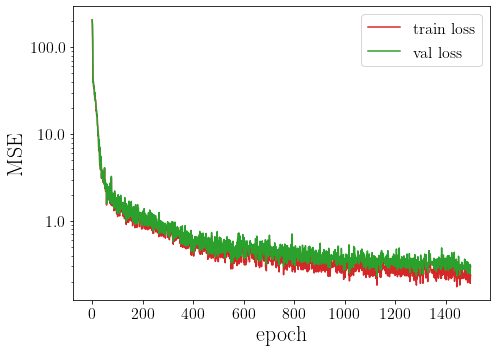

In [35]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses_dr, label="train loss", color=c1 )
axs.plot( val_losses_dr, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "MSE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

Clearly, we can see that dropout has completely prevented over-training!

### L2 regularisation

Similar to dropout L2 regularisation is a method which can be used to reduce overfitting.

It simply works by adding a term of the form: ~$\lambda|\omega|^2 $
to the loss function. In our case we get:

$$L = MSE + \lambda|\omega|^2$$

where $\lambda$ is an additional hyperparameter.

One possible interpretation of L2-regularisation is having a normal prior over weight space where $\lambda$ is related to the width of the prior and the central value is set to 0. This normal prior resctricts the model complexity by punishing models with a weight configuration far away from its central value of 0.

-----------------------------------




Let's just copy paste everything from before...

In [61]:
# a useful function to present things clearer
def seperator():
    print( "-----------------------------------------------" )

# define parameters
ipt_dim = 20
opt_dim = 1
hdn_dim = 50
batch_size = 64
trn_dataloader = DataLoader( trn_dataset, batch_size=batch_size, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=batch_size, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=batch_size, shuffle=True )
epochs = 1500

# re-initialise the model and the optimizer
hdn_dim = 50
model = amp_net( hdn_dim=hdn_dim ).to(device) # model without Dropout!
learning_rate = 5e-4

In pytorch L2 regularisation can be added via the argument 'weight_decay' of the optimizer.

In [62]:
weight_decay = 1e-1
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate, weight_decay=weight_decay )

As a side note:

An alternative explicit implementation would be:

weight_decay = 1e-2\
l2_norm = sum(torch.linalg.norm(p, 2) for p in model.parameters())

loss = loss + weight_decay * l2_norm

In [63]:
seperator()
print( "model architecture ")
seperator()
print( model )

# track train and val losses
trn_losses_l2 = []
val_losses_l2 = []

for t in range(epochs):
    seperator()
    print( f"Epoch {t+1}" )
    seperator()
    train_epoch( trn_dataloader, model, loss_fn, optimizer )
    seperator()
    trn_loss = trn_pass( trn_dataloader, model, loss_fn )
    trn_losses_l2.append( trn_loss )
    seperator()
    val_loss = val_pass( val_dataloader, model, loss_fn )
    val_losses_l2.append( val_loss )
    seperator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 217.119827  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 211.754169
-----------------------------------------------
avg val loss per batch: 213.837885
-----------------------------------------------
|
-----------------------------------------------
Epoch 2
-----------------------------------------------
c

avg val loss per batch: 1.059514
-----------------------------------------------
|
-----------------------------------------------
Epoch 23
-----------------------------------------------
current batch loss: 0.586296  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.623790
-----------------------------------------------
avg val loss per batch: 0.795130
-----------------------------------------------
|
-----------------------------------------------
Epoch 24
-----------------------------------------------
current batch loss: 0.484733  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.550877
-----------------------------------------------
avg val loss per batch: 0.755746
-----------------------------------------------
|
-----------------------------------------------
Epoch 25
-----------------------------------------------
current batch loss: 0.818390  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.403734
-----------------------------------------------
|
-----------------------------------------------
Epoch 46
-----------------------------------------------
current batch loss: 0.254548  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.273745
-----------------------------------------------
avg val loss per batch: 0.408687
-----------------------------------------------
|
-----------------------------------------------
Epoch 47
-----------------------------------------------
current batch loss: 0.195824  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.268404
-----------------------------------------------
avg val loss per batch: 0.426102
-----------------------------------------------
|
-----------------------------------------------
Epoch 48
-----------------------------------------------
current batch loss: 0.234374  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.378989
-----------------------------------------------
|
-----------------------------------------------
Epoch 69
-----------------------------------------------
current batch loss: 0.273260  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.228013
-----------------------------------------------
avg val loss per batch: 0.379134
-----------------------------------------------
|
-----------------------------------------------
Epoch 70
-----------------------------------------------
current batch loss: 0.161561  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.229097
-----------------------------------------------
avg val loss per batch: 0.380105
-----------------------------------------------
|
-----------------------------------------------
Epoch 71
-----------------------------------------------
current batch loss: 0.154932  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.349999
-----------------------------------------------
|
-----------------------------------------------
Epoch 92
-----------------------------------------------
current batch loss: 0.166624  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.213496
-----------------------------------------------
avg val loss per batch: 0.337862
-----------------------------------------------
|
-----------------------------------------------
Epoch 93
-----------------------------------------------
current batch loss: 0.320632  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.214771
-----------------------------------------------
avg val loss per batch: 0.378623
-----------------------------------------------
|
-----------------------------------------------
Epoch 94
-----------------------------------------------
current batch loss: 0.197209  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.367506
-----------------------------------------------
|
-----------------------------------------------
Epoch 115
-----------------------------------------------
current batch loss: 0.253467  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.197991
-----------------------------------------------
avg val loss per batch: 0.345738
-----------------------------------------------
|
-----------------------------------------------
Epoch 116
-----------------------------------------------
current batch loss: 0.169527  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.197411
-----------------------------------------------
avg val loss per batch: 0.333181
-----------------------------------------------
|
-----------------------------------------------
Epoch 117
-----------------------------------------------
current batch loss: 0.196403  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.321104
-----------------------------------------------
|
-----------------------------------------------
Epoch 138
-----------------------------------------------
current batch loss: 0.164617  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.185824
-----------------------------------------------
avg val loss per batch: 0.315328
-----------------------------------------------
|
-----------------------------------------------
Epoch 139
-----------------------------------------------
current batch loss: 0.134647  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.183786
-----------------------------------------------
avg val loss per batch: 0.324149
-----------------------------------------------
|
-----------------------------------------------
Epoch 140
-----------------------------------------------
current batch loss: 0.200647  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.296160
-----------------------------------------------
|
-----------------------------------------------
Epoch 161
-----------------------------------------------
current batch loss: 0.177407  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.176699
-----------------------------------------------
avg val loss per batch: 0.295437
-----------------------------------------------
|
-----------------------------------------------
Epoch 162
-----------------------------------------------
current batch loss: 0.257782  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.177248
-----------------------------------------------
avg val loss per batch: 0.289557
-----------------------------------------------
|
-----------------------------------------------
Epoch 163
-----------------------------------------------
current batch loss: 0.134309  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.284267
-----------------------------------------------
|
-----------------------------------------------
Epoch 184
-----------------------------------------------
current batch loss: 0.160092  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.163769
-----------------------------------------------
avg val loss per batch: 0.279057
-----------------------------------------------
|
-----------------------------------------------
Epoch 185
-----------------------------------------------
current batch loss: 0.127226  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.167489
-----------------------------------------------
avg val loss per batch: 0.289465
-----------------------------------------------
|
-----------------------------------------------
Epoch 186
-----------------------------------------------
current batch loss: 0.211992  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.272030
-----------------------------------------------
|
-----------------------------------------------
Epoch 207
-----------------------------------------------
current batch loss: 0.193842  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.153177
-----------------------------------------------
avg val loss per batch: 0.268443
-----------------------------------------------
|
-----------------------------------------------
Epoch 208
-----------------------------------------------
current batch loss: 0.218817  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.157004
-----------------------------------------------
avg val loss per batch: 0.279881
-----------------------------------------------
|
-----------------------------------------------
Epoch 209
-----------------------------------------------
current batch loss: 0.194010  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.283918
-----------------------------------------------
|
-----------------------------------------------
Epoch 230
-----------------------------------------------
current batch loss: 0.154869  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.150919
-----------------------------------------------
avg val loss per batch: 0.256731
-----------------------------------------------
|
-----------------------------------------------
Epoch 231
-----------------------------------------------
current batch loss: 0.095916  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.181919
-----------------------------------------------
avg val loss per batch: 0.267995
-----------------------------------------------
|
-----------------------------------------------
Epoch 232
-----------------------------------------------
current batch loss: 0.209734  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.242479
-----------------------------------------------
|
-----------------------------------------------
Epoch 253
-----------------------------------------------
current batch loss: 0.176061  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.143818
-----------------------------------------------
avg val loss per batch: 0.252527
-----------------------------------------------
|
-----------------------------------------------
Epoch 254
-----------------------------------------------
current batch loss: 0.103810  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.141920
-----------------------------------------------
avg val loss per batch: 0.239658
-----------------------------------------------
|
-----------------------------------------------
Epoch 255
-----------------------------------------------
current batch loss: 0.122138  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.234335
-----------------------------------------------
|
-----------------------------------------------
Epoch 276
-----------------------------------------------
current batch loss: 0.105706  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.166964
-----------------------------------------------
avg val loss per batch: 0.277743
-----------------------------------------------
|
-----------------------------------------------
Epoch 277
-----------------------------------------------
current batch loss: 0.214466  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.144915
-----------------------------------------------
avg val loss per batch: 0.253663
-----------------------------------------------
|
-----------------------------------------------
Epoch 278
-----------------------------------------------
current batch loss: 0.169704  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.237292
-----------------------------------------------
|
-----------------------------------------------
Epoch 299
-----------------------------------------------
current batch loss: 0.117333  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.151063
-----------------------------------------------
avg val loss per batch: 0.260401
-----------------------------------------------
|
-----------------------------------------------
Epoch 300
-----------------------------------------------
current batch loss: 0.206227  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.147028
-----------------------------------------------
avg val loss per batch: 0.250510
-----------------------------------------------
|
-----------------------------------------------
Epoch 301
-----------------------------------------------
current batch loss: 0.188053  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.243079
-----------------------------------------------
|
-----------------------------------------------
Epoch 322
-----------------------------------------------
current batch loss: 0.204714  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.130643
-----------------------------------------------
avg val loss per batch: 0.217717
-----------------------------------------------
|
-----------------------------------------------
Epoch 323
-----------------------------------------------
current batch loss: 0.125112  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.130385
-----------------------------------------------
avg val loss per batch: 0.226234
-----------------------------------------------
|
-----------------------------------------------
Epoch 324
-----------------------------------------------
current batch loss: 0.081223  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.214236
-----------------------------------------------
|
-----------------------------------------------
Epoch 345
-----------------------------------------------
current batch loss: 0.123266  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.140464
-----------------------------------------------
avg val loss per batch: 0.218809
-----------------------------------------------
|
-----------------------------------------------
Epoch 346
-----------------------------------------------
current batch loss: 0.148517  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.167639
-----------------------------------------------
avg val loss per batch: 0.267941
-----------------------------------------------
|
-----------------------------------------------
Epoch 347
-----------------------------------------------
current batch loss: 0.100629  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.204215
-----------------------------------------------
|
-----------------------------------------------
Epoch 368
-----------------------------------------------
current batch loss: 0.095087  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.129369
-----------------------------------------------
avg val loss per batch: 0.209277
-----------------------------------------------
|
-----------------------------------------------
Epoch 369
-----------------------------------------------
current batch loss: 0.119385  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.130104
-----------------------------------------------
avg val loss per batch: 0.213739
-----------------------------------------------
|
-----------------------------------------------
Epoch 370
-----------------------------------------------
current batch loss: 0.184834  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.210518
-----------------------------------------------
|
-----------------------------------------------
Epoch 391
-----------------------------------------------
current batch loss: 0.095882  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.122880
-----------------------------------------------
avg val loss per batch: 0.204686
-----------------------------------------------
|
-----------------------------------------------
Epoch 392
-----------------------------------------------
current batch loss: 0.108092  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.126979
-----------------------------------------------
avg val loss per batch: 0.215230
-----------------------------------------------
|
-----------------------------------------------
Epoch 393
-----------------------------------------------
current batch loss: 0.129011  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.195503
-----------------------------------------------
|
-----------------------------------------------
Epoch 414
-----------------------------------------------
current batch loss: 0.082980  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.155916
-----------------------------------------------
avg val loss per batch: 0.229225
-----------------------------------------------
|
-----------------------------------------------
Epoch 415
-----------------------------------------------
current batch loss: 0.122955  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.142435
-----------------------------------------------
avg val loss per batch: 0.216438
-----------------------------------------------
|
-----------------------------------------------
Epoch 416
-----------------------------------------------
current batch loss: 0.134470  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.258670
-----------------------------------------------
|
-----------------------------------------------
Epoch 437
-----------------------------------------------
current batch loss: 0.215913  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.124423
-----------------------------------------------
avg val loss per batch: 0.210027
-----------------------------------------------
|
-----------------------------------------------
Epoch 438
-----------------------------------------------
current batch loss: 0.101532  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.140921
-----------------------------------------------
avg val loss per batch: 0.217643
-----------------------------------------------
|
-----------------------------------------------
Epoch 439
-----------------------------------------------
current batch loss: 0.175482  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.204203
-----------------------------------------------
|
-----------------------------------------------
Epoch 460
-----------------------------------------------
current batch loss: 0.150329  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.116843
-----------------------------------------------
avg val loss per batch: 0.193779
-----------------------------------------------
|
-----------------------------------------------
Epoch 461
-----------------------------------------------
current batch loss: 0.145353  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.131423
-----------------------------------------------
avg val loss per batch: 0.202963
-----------------------------------------------
|
-----------------------------------------------
Epoch 462
-----------------------------------------------
current batch loss: 0.094662  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.197369
-----------------------------------------------
|
-----------------------------------------------
Epoch 483
-----------------------------------------------
current batch loss: 0.110865  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.114933
-----------------------------------------------
avg val loss per batch: 0.191904
-----------------------------------------------
|
-----------------------------------------------
Epoch 484
-----------------------------------------------
current batch loss: 0.131836  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.112526
-----------------------------------------------
avg val loss per batch: 0.189608
-----------------------------------------------
|
-----------------------------------------------
Epoch 485
-----------------------------------------------
current batch loss: 0.117040  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.190829
-----------------------------------------------
|
-----------------------------------------------
Epoch 506
-----------------------------------------------
current batch loss: 0.107452  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.108655
-----------------------------------------------
avg val loss per batch: 0.183199
-----------------------------------------------
|
-----------------------------------------------
Epoch 507
-----------------------------------------------
current batch loss: 0.066905  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.110601
-----------------------------------------------
avg val loss per batch: 0.187554
-----------------------------------------------
|
-----------------------------------------------
Epoch 508
-----------------------------------------------
current batch loss: 0.074030  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.187984
-----------------------------------------------
|
-----------------------------------------------
Epoch 529
-----------------------------------------------
current batch loss: 0.056969  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.115040
-----------------------------------------------
avg val loss per batch: 0.194521
-----------------------------------------------
|
-----------------------------------------------
Epoch 530
-----------------------------------------------
current batch loss: 0.133825  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.109575
-----------------------------------------------
avg val loss per batch: 0.186240
-----------------------------------------------
|
-----------------------------------------------
Epoch 531
-----------------------------------------------
current batch loss: 0.085646  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.182571
-----------------------------------------------
|
-----------------------------------------------
Epoch 552
-----------------------------------------------
current batch loss: 0.109139  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.110946
-----------------------------------------------
avg val loss per batch: 0.184874
-----------------------------------------------
|
-----------------------------------------------
Epoch 553
-----------------------------------------------
current batch loss: 0.132726  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.130404
-----------------------------------------------
avg val loss per batch: 0.211161
-----------------------------------------------
|
-----------------------------------------------
Epoch 554
-----------------------------------------------
current batch loss: 0.149263  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.184862
-----------------------------------------------
|
-----------------------------------------------
Epoch 575
-----------------------------------------------
current batch loss: 0.140025  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.107129
-----------------------------------------------
avg val loss per batch: 0.180894
-----------------------------------------------
|
-----------------------------------------------
Epoch 576
-----------------------------------------------
current batch loss: 0.095591  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.105105
-----------------------------------------------
avg val loss per batch: 0.181008
-----------------------------------------------
|
-----------------------------------------------
Epoch 577
-----------------------------------------------
current batch loss: 0.088480  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.196929
-----------------------------------------------
|
-----------------------------------------------
Epoch 598
-----------------------------------------------
current batch loss: 0.115920  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.124614
-----------------------------------------------
avg val loss per batch: 0.189246
-----------------------------------------------
|
-----------------------------------------------
Epoch 599
-----------------------------------------------
current batch loss: 0.105198  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.110475
-----------------------------------------------
avg val loss per batch: 0.180030
-----------------------------------------------
|
-----------------------------------------------
Epoch 600
-----------------------------------------------
current batch loss: 0.074848  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.216730
-----------------------------------------------
|
-----------------------------------------------
Epoch 621
-----------------------------------------------
current batch loss: 0.103109  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.103724
-----------------------------------------------
avg val loss per batch: 0.176084
-----------------------------------------------
|
-----------------------------------------------
Epoch 622
-----------------------------------------------
current batch loss: 0.119884  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.111767
-----------------------------------------------
avg val loss per batch: 0.178748
-----------------------------------------------
|
-----------------------------------------------
Epoch 623
-----------------------------------------------
current batch loss: 0.062299  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.170085
-----------------------------------------------
|
-----------------------------------------------
Epoch 644
-----------------------------------------------
current batch loss: 0.118885  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.100048
-----------------------------------------------
avg val loss per batch: 0.173312
-----------------------------------------------
|
-----------------------------------------------
Epoch 645
-----------------------------------------------
current batch loss: 0.112417  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.101705
-----------------------------------------------
avg val loss per batch: 0.173245
-----------------------------------------------
|
-----------------------------------------------
Epoch 646
-----------------------------------------------
current batch loss: 0.051883  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.192977
-----------------------------------------------
|
-----------------------------------------------
Epoch 667
-----------------------------------------------
current batch loss: 0.125747  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.102548
-----------------------------------------------
avg val loss per batch: 0.170448
-----------------------------------------------
|
-----------------------------------------------
Epoch 668
-----------------------------------------------
current batch loss: 0.091151  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.103588
-----------------------------------------------
avg val loss per batch: 0.169959
-----------------------------------------------
|
-----------------------------------------------
Epoch 669
-----------------------------------------------
current batch loss: 0.088065  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.206444
-----------------------------------------------
|
-----------------------------------------------
Epoch 690
-----------------------------------------------
current batch loss: 0.147179  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.107521
-----------------------------------------------
avg val loss per batch: 0.176345
-----------------------------------------------
|
-----------------------------------------------
Epoch 691
-----------------------------------------------
current batch loss: 0.087002  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.118183
-----------------------------------------------
avg val loss per batch: 0.196588
-----------------------------------------------
|
-----------------------------------------------
Epoch 692
-----------------------------------------------
current batch loss: 0.100229  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.166044
-----------------------------------------------
|
-----------------------------------------------
Epoch 713
-----------------------------------------------
current batch loss: 0.103923  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.103626
-----------------------------------------------
avg val loss per batch: 0.173680
-----------------------------------------------
|
-----------------------------------------------
Epoch 714
-----------------------------------------------
current batch loss: 0.118177  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.105092
-----------------------------------------------
avg val loss per batch: 0.176391
-----------------------------------------------
|
-----------------------------------------------
Epoch 715
-----------------------------------------------
current batch loss: 0.093075  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.163314
-----------------------------------------------
|
-----------------------------------------------
Epoch 736
-----------------------------------------------
current batch loss: 0.090081  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.102506
-----------------------------------------------
avg val loss per batch: 0.166485
-----------------------------------------------
|
-----------------------------------------------
Epoch 737
-----------------------------------------------
current batch loss: 0.115214  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.101387
-----------------------------------------------
avg val loss per batch: 0.168870
-----------------------------------------------
|
-----------------------------------------------
Epoch 738
-----------------------------------------------
current batch loss: 0.100029  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.173036
-----------------------------------------------
|
-----------------------------------------------
Epoch 759
-----------------------------------------------
current batch loss: 0.136814  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.127725
-----------------------------------------------
avg val loss per batch: 0.191314
-----------------------------------------------
|
-----------------------------------------------
Epoch 760
-----------------------------------------------
current batch loss: 0.115875  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.110963
-----------------------------------------------
avg val loss per batch: 0.179102
-----------------------------------------------
|
-----------------------------------------------
Epoch 761
-----------------------------------------------
current batch loss: 0.118816  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.170141
-----------------------------------------------
|
-----------------------------------------------
Epoch 782
-----------------------------------------------
current batch loss: 0.069217  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.097475
-----------------------------------------------
avg val loss per batch: 0.164298
-----------------------------------------------
|
-----------------------------------------------
Epoch 783
-----------------------------------------------
current batch loss: 0.099799  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.098433
-----------------------------------------------
avg val loss per batch: 0.163618
-----------------------------------------------
|
-----------------------------------------------
Epoch 784
-----------------------------------------------
current batch loss: 0.088848  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.172478
-----------------------------------------------
|
-----------------------------------------------
Epoch 805
-----------------------------------------------
current batch loss: 0.093982  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.093918
-----------------------------------------------
avg val loss per batch: 0.161212
-----------------------------------------------
|
-----------------------------------------------
Epoch 806
-----------------------------------------------
current batch loss: 0.085729  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.096971
-----------------------------------------------
avg val loss per batch: 0.161322
-----------------------------------------------
|
-----------------------------------------------
Epoch 807
-----------------------------------------------
current batch loss: 0.090790  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.200589
-----------------------------------------------
|
-----------------------------------------------
Epoch 828
-----------------------------------------------
current batch loss: 0.202851  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.097626
-----------------------------------------------
avg val loss per batch: 0.163545
-----------------------------------------------
|
-----------------------------------------------
Epoch 829
-----------------------------------------------
current batch loss: 0.084338  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.098018
-----------------------------------------------
avg val loss per batch: 0.171234
-----------------------------------------------
|
-----------------------------------------------
Epoch 830
-----------------------------------------------
current batch loss: 0.120316  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.164344
-----------------------------------------------
|
-----------------------------------------------
Epoch 851
-----------------------------------------------
current batch loss: 0.073116  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.096077
-----------------------------------------------
avg val loss per batch: 0.167080
-----------------------------------------------
|
-----------------------------------------------
Epoch 852
-----------------------------------------------
current batch loss: 0.107135  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.097664
-----------------------------------------------
avg val loss per batch: 0.163585
-----------------------------------------------
|
-----------------------------------------------
Epoch 853
-----------------------------------------------
current batch loss: 0.095244  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.165071
-----------------------------------------------
|
-----------------------------------------------
Epoch 874
-----------------------------------------------
current batch loss: 0.112380  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.092624
-----------------------------------------------
avg val loss per batch: 0.160619
-----------------------------------------------
|
-----------------------------------------------
Epoch 875
-----------------------------------------------
current batch loss: 0.091256  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.094062
-----------------------------------------------
avg val loss per batch: 0.158572
-----------------------------------------------
|
-----------------------------------------------
Epoch 876
-----------------------------------------------
current batch loss: 0.109624  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.164563
-----------------------------------------------
|
-----------------------------------------------
Epoch 897
-----------------------------------------------
current batch loss: 0.120935  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.094576
-----------------------------------------------
avg val loss per batch: 0.162446
-----------------------------------------------
|
-----------------------------------------------
Epoch 898
-----------------------------------------------
current batch loss: 0.063952  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.093396
-----------------------------------------------
avg val loss per batch: 0.162864
-----------------------------------------------
|
-----------------------------------------------
Epoch 899
-----------------------------------------------
current batch loss: 0.087767  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.195712
-----------------------------------------------
|
-----------------------------------------------
Epoch 920
-----------------------------------------------
current batch loss: 0.116374  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.128551
-----------------------------------------------
avg val loss per batch: 0.206814
-----------------------------------------------
|
-----------------------------------------------
Epoch 921
-----------------------------------------------
current batch loss: 0.129979  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.115832
-----------------------------------------------
avg val loss per batch: 0.188433
-----------------------------------------------
|
-----------------------------------------------
Epoch 922
-----------------------------------------------
current batch loss: 0.073253  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.194006
-----------------------------------------------
|
-----------------------------------------------
Epoch 943
-----------------------------------------------
current batch loss: 0.112523  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.095553
-----------------------------------------------
avg val loss per batch: 0.165986
-----------------------------------------------
|
-----------------------------------------------
Epoch 944
-----------------------------------------------
current batch loss: 0.107460  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.104201
-----------------------------------------------
avg val loss per batch: 0.166613
-----------------------------------------------
|
-----------------------------------------------
Epoch 945
-----------------------------------------------
current batch loss: 0.082015  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.163909
-----------------------------------------------
|
-----------------------------------------------
Epoch 966
-----------------------------------------------
current batch loss: 0.095453  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.096150
-----------------------------------------------
avg val loss per batch: 0.166420
-----------------------------------------------
|
-----------------------------------------------
Epoch 967
-----------------------------------------------
current batch loss: 0.126404  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.134757
-----------------------------------------------
avg val loss per batch: 0.194598
-----------------------------------------------
|
-----------------------------------------------
Epoch 968
-----------------------------------------------
current batch loss: 0.124422  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.158390
-----------------------------------------------
|
-----------------------------------------------
Epoch 989
-----------------------------------------------
current batch loss: 0.071273  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.093839
-----------------------------------------------
avg val loss per batch: 0.157896
-----------------------------------------------
|
-----------------------------------------------
Epoch 990
-----------------------------------------------
current batch loss: 0.067185  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.102644
-----------------------------------------------
avg val loss per batch: 0.172648
-----------------------------------------------
|
-----------------------------------------------
Epoch 991
-----------------------------------------------
current batch loss: 0.096202  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.164562
-----------------------------------------------
|
-----------------------------------------------
Epoch 1012
-----------------------------------------------
current batch loss: 0.083281  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.096579
-----------------------------------------------
avg val loss per batch: 0.165273
-----------------------------------------------
|
-----------------------------------------------
Epoch 1013
-----------------------------------------------
current batch loss: 0.098702  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.095270
-----------------------------------------------
avg val loss per batch: 0.163455
-----------------------------------------------
|
-----------------------------------------------
Epoch 1014
-----------------------------------------------
current batch loss: 0.081315  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.158240
-----------------------------------------------
|
-----------------------------------------------
Epoch 1035
-----------------------------------------------
current batch loss: 0.081465  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.093196
-----------------------------------------------
avg val loss per batch: 0.161535
-----------------------------------------------
|
-----------------------------------------------
Epoch 1036
-----------------------------------------------
current batch loss: 0.076566  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.089822
-----------------------------------------------
avg val loss per batch: 0.155668
-----------------------------------------------
|
-----------------------------------------------
Epoch 1037
-----------------------------------------------
current batch loss: 0.061434  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.161573
-----------------------------------------------
|
-----------------------------------------------
Epoch 1058
-----------------------------------------------
current batch loss: 0.096925  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.106449
-----------------------------------------------
avg val loss per batch: 0.170152
-----------------------------------------------
|
-----------------------------------------------
Epoch 1059
-----------------------------------------------
current batch loss: 0.098608  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.114436
-----------------------------------------------
avg val loss per batch: 0.178176
-----------------------------------------------
|
-----------------------------------------------
Epoch 1060
-----------------------------------------------
current batch loss: 0.102273  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.164686
-----------------------------------------------
|
-----------------------------------------------
Epoch 1081
-----------------------------------------------
current batch loss: 0.112506  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.094587
-----------------------------------------------
avg val loss per batch: 0.155424
-----------------------------------------------
|
-----------------------------------------------
Epoch 1082
-----------------------------------------------
current batch loss: 0.112634  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.093206
-----------------------------------------------
avg val loss per batch: 0.161297
-----------------------------------------------
|
-----------------------------------------------
Epoch 1083
-----------------------------------------------
current batch loss: 0.113694  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.160016
-----------------------------------------------
|
-----------------------------------------------
Epoch 1104
-----------------------------------------------
current batch loss: 0.076058  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.092850
-----------------------------------------------
avg val loss per batch: 0.159192
-----------------------------------------------
|
-----------------------------------------------
Epoch 1105
-----------------------------------------------
current batch loss: 0.072526  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.092565
-----------------------------------------------
avg val loss per batch: 0.157441
-----------------------------------------------
|
-----------------------------------------------
Epoch 1106
-----------------------------------------------
current batch loss: 0.128475  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.172256
-----------------------------------------------
|
-----------------------------------------------
Epoch 1127
-----------------------------------------------
current batch loss: 0.111356  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.100144
-----------------------------------------------
avg val loss per batch: 0.161194
-----------------------------------------------
|
-----------------------------------------------
Epoch 1128
-----------------------------------------------
current batch loss: 0.101765  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.094475
-----------------------------------------------
avg val loss per batch: 0.159913
-----------------------------------------------
|
-----------------------------------------------
Epoch 1129
-----------------------------------------------
current batch loss: 0.086028  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.159570
-----------------------------------------------
|
-----------------------------------------------
Epoch 1150
-----------------------------------------------
current batch loss: 0.088496  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.103019
-----------------------------------------------
avg val loss per batch: 0.167720
-----------------------------------------------
|
-----------------------------------------------
Epoch 1151
-----------------------------------------------
current batch loss: 0.143678  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.120070
-----------------------------------------------
avg val loss per batch: 0.186645
-----------------------------------------------
|
-----------------------------------------------
Epoch 1152
-----------------------------------------------
current batch loss: 0.157289  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.159620
-----------------------------------------------
|
-----------------------------------------------
Epoch 1173
-----------------------------------------------
current batch loss: 0.081232  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.096371
-----------------------------------------------
avg val loss per batch: 0.161610
-----------------------------------------------
|
-----------------------------------------------
Epoch 1174
-----------------------------------------------
current batch loss: 0.092456  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.102947
-----------------------------------------------
avg val loss per batch: 0.165641
-----------------------------------------------
|
-----------------------------------------------
Epoch 1175
-----------------------------------------------
current batch loss: 0.098042  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.160240
-----------------------------------------------
|
-----------------------------------------------
Epoch 1196
-----------------------------------------------
current batch loss: 0.078245  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.097238
-----------------------------------------------
avg val loss per batch: 0.159805
-----------------------------------------------
|
-----------------------------------------------
Epoch 1197
-----------------------------------------------
current batch loss: 0.103778  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.094554
-----------------------------------------------
avg val loss per batch: 0.161691
-----------------------------------------------
|
-----------------------------------------------
Epoch 1198
-----------------------------------------------
current batch loss: 0.111311  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.160066
-----------------------------------------------
|
-----------------------------------------------
Epoch 1219
-----------------------------------------------
current batch loss: 0.090372  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.102690
-----------------------------------------------
avg val loss per batch: 0.173202
-----------------------------------------------
|
-----------------------------------------------
Epoch 1220
-----------------------------------------------
current batch loss: 0.119021  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.095441
-----------------------------------------------
avg val loss per batch: 0.159954
-----------------------------------------------
|
-----------------------------------------------
Epoch 1221
-----------------------------------------------
current batch loss: 0.071779  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.166930
-----------------------------------------------
|
-----------------------------------------------
Epoch 1242
-----------------------------------------------
current batch loss: 0.083348  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.092496
-----------------------------------------------
avg val loss per batch: 0.154813
-----------------------------------------------
|
-----------------------------------------------
Epoch 1243
-----------------------------------------------
current batch loss: 0.106384  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.094570
-----------------------------------------------
avg val loss per batch: 0.159817
-----------------------------------------------
|
-----------------------------------------------
Epoch 1244
-----------------------------------------------
current batch loss: 0.088143  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.159250
-----------------------------------------------
|
-----------------------------------------------
Epoch 1265
-----------------------------------------------
current batch loss: 0.121571  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.112769
-----------------------------------------------
avg val loss per batch: 0.175820
-----------------------------------------------
|
-----------------------------------------------
Epoch 1266
-----------------------------------------------
current batch loss: 0.088882  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.097483
-----------------------------------------------
avg val loss per batch: 0.166385
-----------------------------------------------
|
-----------------------------------------------
Epoch 1267
-----------------------------------------------
current batch loss: 0.075481  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.160252
-----------------------------------------------
|
-----------------------------------------------
Epoch 1288
-----------------------------------------------
current batch loss: 0.064530  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.091934
-----------------------------------------------
avg val loss per batch: 0.157093
-----------------------------------------------
|
-----------------------------------------------
Epoch 1289
-----------------------------------------------
current batch loss: 0.100311  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.102082
-----------------------------------------------
avg val loss per batch: 0.171575
-----------------------------------------------
|
-----------------------------------------------
Epoch 1290
-----------------------------------------------
current batch loss: 0.068082  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.157673
-----------------------------------------------
|
-----------------------------------------------
Epoch 1311
-----------------------------------------------
current batch loss: 0.073852  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.095362
-----------------------------------------------
avg val loss per batch: 0.156923
-----------------------------------------------
|
-----------------------------------------------
Epoch 1312
-----------------------------------------------
current batch loss: 0.073985  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.094664
-----------------------------------------------
avg val loss per batch: 0.161240
-----------------------------------------------
|
-----------------------------------------------
Epoch 1313
-----------------------------------------------
current batch loss: 0.121211  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.167461
-----------------------------------------------
|
-----------------------------------------------
Epoch 1334
-----------------------------------------------
current batch loss: 0.100090  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.100434
-----------------------------------------------
avg val loss per batch: 0.167433
-----------------------------------------------
|
-----------------------------------------------
Epoch 1335
-----------------------------------------------
current batch loss: 0.078355  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.097273
-----------------------------------------------
avg val loss per batch: 0.165597
-----------------------------------------------
|
-----------------------------------------------
Epoch 1336
-----------------------------------------------
current batch loss: 0.069654  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.167806
-----------------------------------------------
|
-----------------------------------------------
Epoch 1357
-----------------------------------------------
current batch loss: 0.116754  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.093006
-----------------------------------------------
avg val loss per batch: 0.161036
-----------------------------------------------
|
-----------------------------------------------
Epoch 1358
-----------------------------------------------
current batch loss: 0.083963  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.096394
-----------------------------------------------
avg val loss per batch: 0.164501
-----------------------------------------------
|
-----------------------------------------------
Epoch 1359
-----------------------------------------------
current batch loss: 0.081362  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.171471
-----------------------------------------------
|
-----------------------------------------------
Epoch 1380
-----------------------------------------------
current batch loss: 0.091925  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.098195
-----------------------------------------------
avg val loss per batch: 0.163096
-----------------------------------------------
|
-----------------------------------------------
Epoch 1381
-----------------------------------------------
current batch loss: 0.080061  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.104236
-----------------------------------------------
avg val loss per batch: 0.167607
-----------------------------------------------
|
-----------------------------------------------
Epoch 1382
-----------------------------------------------
current batch loss: 0.104056  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.160456
-----------------------------------------------
|
-----------------------------------------------
Epoch 1403
-----------------------------------------------
current batch loss: 0.073662  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.115888
-----------------------------------------------
avg val loss per batch: 0.182228
-----------------------------------------------
|
-----------------------------------------------
Epoch 1404
-----------------------------------------------
current batch loss: 0.123990  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.092111
-----------------------------------------------
avg val loss per batch: 0.160130
-----------------------------------------------
|
-----------------------------------------------
Epoch 1405
-----------------------------------------------
current batch loss: 0.081674  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.161278
-----------------------------------------------
|
-----------------------------------------------
Epoch 1426
-----------------------------------------------
current batch loss: 0.090888  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.104298
-----------------------------------------------
avg val loss per batch: 0.169778
-----------------------------------------------
|
-----------------------------------------------
Epoch 1427
-----------------------------------------------
current batch loss: 0.079321  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.096079
-----------------------------------------------
avg val loss per batch: 0.162743
-----------------------------------------------
|
-----------------------------------------------
Epoch 1428
-----------------------------------------------
current batch loss: 0.111515  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.154046
-----------------------------------------------
|
-----------------------------------------------
Epoch 1449
-----------------------------------------------
current batch loss: 0.097254  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.092703
-----------------------------------------------
avg val loss per batch: 0.158755
-----------------------------------------------
|
-----------------------------------------------
Epoch 1450
-----------------------------------------------
current batch loss: 0.069659  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.096926
-----------------------------------------------
avg val loss per batch: 0.162442
-----------------------------------------------
|
-----------------------------------------------
Epoch 1451
-----------------------------------------------
current batch loss: 0.081637  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.175230
-----------------------------------------------
|
-----------------------------------------------
Epoch 1472
-----------------------------------------------
current batch loss: 0.124664  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.130654
-----------------------------------------------
avg val loss per batch: 0.194843
-----------------------------------------------
|
-----------------------------------------------
Epoch 1473
-----------------------------------------------
current batch loss: 0.177114  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.091648
-----------------------------------------------
avg val loss per batch: 0.158759
-----------------------------------------------
|
-----------------------------------------------
Epoch 1474
-----------------------------------------------
current batch loss: 0.082723  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.155003
-----------------------------------------------
|
-----------------------------------------------
Epoch 1495
-----------------------------------------------
current batch loss: 0.090121  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.089054
-----------------------------------------------
avg val loss per batch: 0.158926
-----------------------------------------------
|
-----------------------------------------------
Epoch 1496
-----------------------------------------------
current batch loss: 0.132295  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.090747
-----------------------------------------------
avg val loss per batch: 0.156949
-----------------------------------------------
|
-----------------------------------------------
Epoch 1497
-----------------------------------------------
current batch loss: 0.097086  [    0/ 1000]
----------------------------------------

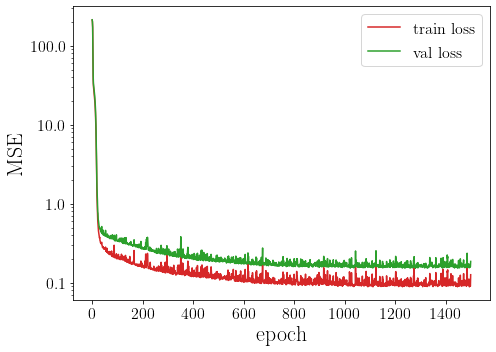

In [64]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses_l2, label="train loss", color=c1 )
axs.plot( val_losses_l2, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "MSE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

Clearly the L2 regularisation has worked in reducing the over-fitting!

L1 regularisation should have a similar effect, try it out!

### Early stopping

As we saw in one of the previous plots in a training without any regularization the validation loss typically stops decreasing after a while (or in the worst case even starts increasing) while the training loss keeps on decreasining. The idea of Early Stopping is to simply stop the training when this happens.

------------
Copy paste again..

In [74]:
# a useful function to present things clearer
def seperator():
    print( "-----------------------------------------------" )

# define parameters
ipt_dim = 20
opt_dim = 1
hdn_dim = 50
batch_size = 64
trn_dataloader = DataLoader( trn_dataset, batch_size=batch_size, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=batch_size, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=batch_size, shuffle=True )
epochs = 1500

# re-initialise the model and the optimizer
hdn_dim = 50
model = amp_net( hdn_dim=hdn_dim ).to(device) # model without Dropout!
learning_rate = 5e-4
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )

The trigger condition can be arbitrarily complicated but in its simpliest version we just compare the current value of the validation loss with the previous value. However, because the validation dataset is typically small and the validation loss therefore prone to statistical fluctuations, we should not immediately stop the training the first time the breaking condition is triggered. Instead, we introduce the new hyperparameter 'patience' which tells us how many epochs we want to wait before stopping the training.

In [75]:
seperator()
print( "model architecture ")
seperator()
print( model )

# track train and val losses
trn_losses_es = []
val_losses_es = []

# patience of EarlyStopping in number of epochs
patience = 4

# set counter to 0 for early stopping
trigger_counter = 0
val_loss_last = 1e10

for t in range(epochs):
    seperator()
    print( f"Epoch {t+1}" )
    seperator()
    train_epoch( trn_dataloader, model, loss_fn, optimizer )
    seperator()
    trn_loss = trn_pass( trn_dataloader, model, loss_fn )
    trn_losses_es.append( trn_loss )
    seperator()
    val_loss = val_pass( val_dataloader, model, loss_fn )
    val_losses_es.append( val_loss )
    
    #######################
    # early stopping
    if val_loss > val_loss_last:
        trigger_counter += 1
    else:
        trigger_counter = 0
        
    if trigger_counter >= patience:
        print("EarlyStopping got triggered! Stop training!")
        break
    
    val_loss_last = val_loss
    #######################
    
    seperator()
    print( "|" )
    
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 214.975861  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 211.139175
-----------------------------------------------
avg val loss per batch: 212.908908
-----------------------------------------------
|
-----------------------------------------------
Epoch 2
-----------------------------------------------
c

avg val loss per batch: 2.729510
-----------------------------------------------
|
-----------------------------------------------
Epoch 23
-----------------------------------------------
current batch loss: 1.630782  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.939649
-----------------------------------------------
avg val loss per batch: 2.226880
-----------------------------------------------
|
-----------------------------------------------
Epoch 24
-----------------------------------------------
current batch loss: 1.431731  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 1.366617
-----------------------------------------------
avg val loss per batch: 1.664870
-----------------------------------------------
|
-----------------------------------------------
Epoch 25
-----------------------------------------------
current batch loss: 2.415553  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.570129
-----------------------------------------------
|
-----------------------------------------------
Epoch 46
-----------------------------------------------
current batch loss: 0.402348  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.448909
-----------------------------------------------
avg val loss per batch: 0.571808
-----------------------------------------------
|
-----------------------------------------------
Epoch 47
-----------------------------------------------
current batch loss: 0.435268  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.425942
-----------------------------------------------
avg val loss per batch: 0.550052
-----------------------------------------------
|
-----------------------------------------------
Epoch 48
-----------------------------------------------
current batch loss: 0.394969  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.476906
-----------------------------------------------
|
-----------------------------------------------
Epoch 69
-----------------------------------------------
current batch loss: 0.223643  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.315169
-----------------------------------------------
avg val loss per batch: 0.483042
-----------------------------------------------
|
-----------------------------------------------
Epoch 70
-----------------------------------------------
current batch loss: 0.314445  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.321171
-----------------------------------------------
avg val loss per batch: 0.494759
-----------------------------------------------
|
-----------------------------------------------
Epoch 71
-----------------------------------------------
current batch loss: 0.244188  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.469260
-----------------------------------------------
|
-----------------------------------------------
Epoch 92
-----------------------------------------------
current batch loss: 0.303478  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.360668
-----------------------------------------------
avg val loss per batch: 0.507383
-----------------------------------------------
|
-----------------------------------------------
Epoch 93
-----------------------------------------------
current batch loss: 0.357573  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.275918
-----------------------------------------------
avg val loss per batch: 0.470433
-----------------------------------------------
|
-----------------------------------------------
Epoch 94
-----------------------------------------------
current batch loss: 0.370017  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.429551
-----------------------------------------------
|
-----------------------------------------------
Epoch 115
-----------------------------------------------
current batch loss: 0.200122  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.246126
-----------------------------------------------
avg val loss per batch: 0.451342
-----------------------------------------------
|
-----------------------------------------------
Epoch 116
-----------------------------------------------
current batch loss: 0.215083  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.243697
-----------------------------------------------
avg val loss per batch: 0.430292
-----------------------------------------------
|
-----------------------------------------------
Epoch 117
-----------------------------------------------
current batch loss: 0.273184  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.432367
-----------------------------------------------
|
-----------------------------------------------
Epoch 138
-----------------------------------------------
current batch loss: 0.305725  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.229355
-----------------------------------------------
avg val loss per batch: 0.426016
-----------------------------------------------
|
-----------------------------------------------
Epoch 139
-----------------------------------------------
current batch loss: 0.211997  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.225018
-----------------------------------------------
avg val loss per batch: 0.418594
-----------------------------------------------
|
-----------------------------------------------
Epoch 140
-----------------------------------------------
current batch loss: 0.184931  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.479907
-----------------------------------------------
|
-----------------------------------------------
Epoch 161
-----------------------------------------------
current batch loss: 0.234045  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.208156
-----------------------------------------------
avg val loss per batch: 0.401495
-----------------------------------------------
|
-----------------------------------------------
Epoch 162
-----------------------------------------------
current batch loss: 0.179606  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.245688
-----------------------------------------------
avg val loss per batch: 0.427329
-----------------------------------------------
|
-----------------------------------------------
Epoch 163
-----------------------------------------------
current batch loss: 0.251566  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.398404
-----------------------------------------------
|
-----------------------------------------------
Epoch 184
-----------------------------------------------
current batch loss: 0.255062  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.214401
-----------------------------------------------
avg val loss per batch: 0.445541
-----------------------------------------------
|
-----------------------------------------------
Epoch 185
-----------------------------------------------
current batch loss: 0.191953  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.205669
-----------------------------------------------
avg val loss per batch: 0.415563
-----------------------------------------------
|
-----------------------------------------------
Epoch 186
-----------------------------------------------
current batch loss: 0.277810  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.382836
-----------------------------------------------
|
-----------------------------------------------
Epoch 207
-----------------------------------------------
current batch loss: 0.208571  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.193233
-----------------------------------------------
avg val loss per batch: 0.382225
-----------------------------------------------
|
-----------------------------------------------
Epoch 208
-----------------------------------------------
current batch loss: 0.160616  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.178770
-----------------------------------------------
avg val loss per batch: 0.381895
-----------------------------------------------
|
-----------------------------------------------
Epoch 209
-----------------------------------------------
current batch loss: 0.182971  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.378450
-----------------------------------------------
|
-----------------------------------------------
Epoch 230
-----------------------------------------------
current batch loss: 0.136039  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.166451
-----------------------------------------------
avg val loss per batch: 0.379665
-----------------------------------------------
|
-----------------------------------------------
Epoch 231
-----------------------------------------------
current batch loss: 0.160903  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.166798
-----------------------------------------------
avg val loss per batch: 0.383455
-----------------------------------------------
|
-----------------------------------------------
Epoch 232
-----------------------------------------------
current batch loss: 0.220866  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.354628
-----------------------------------------------
|
-----------------------------------------------
Epoch 253
-----------------------------------------------
current batch loss: 0.203329  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.151295
-----------------------------------------------
avg val loss per batch: 0.351338
-----------------------------------------------
|
-----------------------------------------------
Epoch 254
-----------------------------------------------
current batch loss: 0.201559  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.149020
-----------------------------------------------
avg val loss per batch: 0.361155
-----------------------------------------------
|
-----------------------------------------------
Epoch 255
-----------------------------------------------
current batch loss: 0.118025  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.346898
-----------------------------------------------
|
-----------------------------------------------
Epoch 276
-----------------------------------------------
current batch loss: 0.111924  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.143199
-----------------------------------------------
avg val loss per batch: 0.362375
-----------------------------------------------
|
-----------------------------------------------
Epoch 277
-----------------------------------------------
current batch loss: 0.150389  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.150628
-----------------------------------------------
avg val loss per batch: 0.336350
-----------------------------------------------
|
-----------------------------------------------
Epoch 278
-----------------------------------------------
current batch loss: 0.119048  [    0/ 1000]
-------------------------------------------

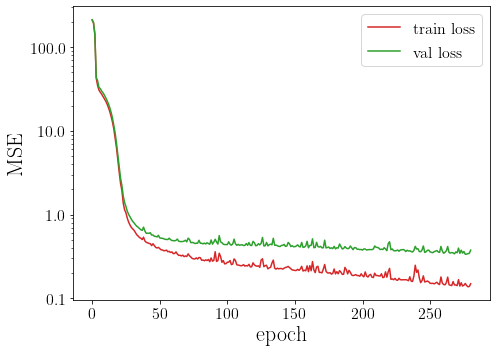

In [76]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses_es, label="train loss", color=c1 )
axs.plot( val_losses_es, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "MSE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

We can see here that the network has stopped training before the training loss diverges too far from the validation loss.

### Batch normalisation

Batch normalisation is not a method to prevent over-fitting, so we do not expect it to do that.  The point of batch normalisation is to make the training more efficient.  It's difficult to see the benefits of this regularisation method with the dataset we're using here, although it is still useful to learn how to implement it.  It works by normalising the data as it passes between the layers, keeping the distribution (i.e. mean and variance) of the data constant throughout training.  This means that the weights in a network layer do not have to adapt to simple changes in the distribution of the data in a previous layer of the network.

In [81]:
class amp_net_bn( nn.Module ):
    
    # default hdn_dim is 30, but can be changed upon initialisation
    def __init__( self, hdn_dim=30 ):
        
        super( amp_net_bn, self ).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear( ipt_dim, hdn_dim ),
            nn.BatchNorm1d(hdn_dim),
            nn.ReLU(),
            nn.Linear( hdn_dim, hdn_dim ),
            nn.BatchNorm1d(hdn_dim),
            nn.ReLU(),
            nn.Linear( hdn_dim, hdn_dim ),
            nn.BatchNorm1d(hdn_dim),
            nn.ReLU(),
            nn.Linear( hdn_dim, hdn_dim ),
            nn.BatchNorm1d(hdn_dim),
            nn.ReLU(),
            nn.Linear( hdn_dim, opt_dim ),
        )

    def forward( self, x ):
        out = self.linear_relu_stack( x )
        return out

In [87]:
# a useful function to present things clearer
def seperator():
    print( "-----------------------------------------------" )

# define parameters
ipt_dim = 20
opt_dim = 1
hdn_dim = 50
batch_size = 64
trn_dataloader = DataLoader( trn_dataset, batch_size=batch_size, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=batch_size, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=batch_size, shuffle=True )
epochs = 1500

# re-initialise the model and the optimizer
hdn_dim = 50
model_bn = amp_net_bn( hdn_dim=hdn_dim ).to(device)
learning_rate = 5e-4

optimizer = torch.optim.Adam( model_bn.parameters(), lr=learning_rate)

In [88]:
seperator()
print( "model architecture ")
seperator()
print( model_bn )

# track train and val losses
trn_losses_bn = []
val_losses_bn = []

# set counter to 0 for early stopping
trigger_counter = 0
val_loss_last = 1e10
for t in range(epochs):
    seperator()
    print( f"Epoch {t+1}" )
    seperator()
    train_epoch( trn_dataloader, model_bn, loss_fn, optimizer )
    seperator()
    model_bn.eval()
    trn_loss = trn_pass( trn_dataloader, model_bn, loss_fn )
    trn_losses_bn.append( trn_loss )
    seperator()
    val_loss = val_pass( val_dataloader, model_bn, loss_fn )
    val_losses_bn.append( val_loss )
    model_bn.train()
    
    seperator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
amp_net_bn(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=50, out_features=50, bias=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=1, bias=True)
  )
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
curre

avg val loss per batch: 98.686515
-----------------------------------------------
|
-----------------------------------------------
Epoch 22
-----------------------------------------------
current batch loss: 94.821541  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 90.831423
-----------------------------------------------
avg val loss per batch: 92.701930
-----------------------------------------------
|
-----------------------------------------------
Epoch 23
-----------------------------------------------
current batch loss: 91.051590  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 85.288134
-----------------------------------------------
avg val loss per batch: 87.149178
-----------------------------------------------
|
-----------------------------------------------
Epoch 24
-----------------------------------------------
current batch loss: 82.596840  [    0/ 1000]
--------------------------------------

avg val loss per batch: 8.171044
-----------------------------------------------
|
-----------------------------------------------
Epoch 45
-----------------------------------------------
current batch loss: 6.938852  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 6.519187
-----------------------------------------------
avg val loss per batch: 7.466323
-----------------------------------------------
|
-----------------------------------------------
Epoch 46
-----------------------------------------------
current batch loss: 5.359044  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 5.301050
-----------------------------------------------
avg val loss per batch: 5.995844
-----------------------------------------------
|
-----------------------------------------------
Epoch 47
-----------------------------------------------
current batch loss: 5.389345  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.525881
-----------------------------------------------
|
-----------------------------------------------
Epoch 68
-----------------------------------------------
current batch loss: 0.540851  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.364275
-----------------------------------------------
avg val loss per batch: 0.610866
-----------------------------------------------
|
-----------------------------------------------
Epoch 69
-----------------------------------------------
current batch loss: 0.629191  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.265171
-----------------------------------------------
avg val loss per batch: 0.507237
-----------------------------------------------
|
-----------------------------------------------
Epoch 70
-----------------------------------------------
current batch loss: 0.395414  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.362640
-----------------------------------------------
|
-----------------------------------------------
Epoch 91
-----------------------------------------------
current batch loss: 0.335644  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.160360
-----------------------------------------------
avg val loss per batch: 0.367158
-----------------------------------------------
|
-----------------------------------------------
Epoch 92
-----------------------------------------------
current batch loss: 0.231133  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.164582
-----------------------------------------------
avg val loss per batch: 0.380609
-----------------------------------------------
|
-----------------------------------------------
Epoch 93
-----------------------------------------------
current batch loss: 0.151691  [    0/ 1000]
----------------------------------------------

avg val loss per batch: 0.350060
-----------------------------------------------
|
-----------------------------------------------
Epoch 114
-----------------------------------------------
current batch loss: 0.233686  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.129368
-----------------------------------------------
avg val loss per batch: 0.317697
-----------------------------------------------
|
-----------------------------------------------
Epoch 115
-----------------------------------------------
current batch loss: 0.195417  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.123853
-----------------------------------------------
avg val loss per batch: 0.322722
-----------------------------------------------
|
-----------------------------------------------
Epoch 116
-----------------------------------------------
current batch loss: 0.274223  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.297419
-----------------------------------------------
|
-----------------------------------------------
Epoch 137
-----------------------------------------------
current batch loss: 0.400624  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.144639
-----------------------------------------------
avg val loss per batch: 0.328815
-----------------------------------------------
|
-----------------------------------------------
Epoch 138
-----------------------------------------------
current batch loss: 0.277537  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.106607
-----------------------------------------------
avg val loss per batch: 0.297567
-----------------------------------------------
|
-----------------------------------------------
Epoch 139
-----------------------------------------------
current batch loss: 0.159057  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.275986
-----------------------------------------------
|
-----------------------------------------------
Epoch 160
-----------------------------------------------
current batch loss: 0.119169  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.102838
-----------------------------------------------
avg val loss per batch: 0.290648
-----------------------------------------------
|
-----------------------------------------------
Epoch 161
-----------------------------------------------
current batch loss: 0.151171  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.115861
-----------------------------------------------
avg val loss per batch: 0.298404
-----------------------------------------------
|
-----------------------------------------------
Epoch 162
-----------------------------------------------
current batch loss: 0.187420  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.257486
-----------------------------------------------
|
-----------------------------------------------
Epoch 183
-----------------------------------------------
current batch loss: 0.220192  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.081476
-----------------------------------------------
avg val loss per batch: 0.260499
-----------------------------------------------
|
-----------------------------------------------
Epoch 184
-----------------------------------------------
current batch loss: 0.224878  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.075477
-----------------------------------------------
avg val loss per batch: 0.257961
-----------------------------------------------
|
-----------------------------------------------
Epoch 185
-----------------------------------------------
current batch loss: 0.127412  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.224178
-----------------------------------------------
|
-----------------------------------------------
Epoch 206
-----------------------------------------------
current batch loss: 0.163551  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.062972
-----------------------------------------------
avg val loss per batch: 0.225024
-----------------------------------------------
|
-----------------------------------------------
Epoch 207
-----------------------------------------------
current batch loss: 0.146504  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.075753
-----------------------------------------------
avg val loss per batch: 0.253635
-----------------------------------------------
|
-----------------------------------------------
Epoch 208
-----------------------------------------------
current batch loss: 0.179460  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.231918
-----------------------------------------------
|
-----------------------------------------------
Epoch 229
-----------------------------------------------
current batch loss: 0.114568  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.065254
-----------------------------------------------
avg val loss per batch: 0.242136
-----------------------------------------------
|
-----------------------------------------------
Epoch 230
-----------------------------------------------
current batch loss: 0.200968  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.090401
-----------------------------------------------
avg val loss per batch: 0.260256
-----------------------------------------------
|
-----------------------------------------------
Epoch 231
-----------------------------------------------
current batch loss: 0.155449  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.254017
-----------------------------------------------
|
-----------------------------------------------
Epoch 252
-----------------------------------------------
current batch loss: 0.069439  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.063456
-----------------------------------------------
avg val loss per batch: 0.228319
-----------------------------------------------
|
-----------------------------------------------
Epoch 253
-----------------------------------------------
current batch loss: 0.166968  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.059245
-----------------------------------------------
avg val loss per batch: 0.231491
-----------------------------------------------
|
-----------------------------------------------
Epoch 254
-----------------------------------------------
current batch loss: 0.079283  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.228740
-----------------------------------------------
|
-----------------------------------------------
Epoch 275
-----------------------------------------------
current batch loss: 0.106886  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.056048
-----------------------------------------------
avg val loss per batch: 0.206184
-----------------------------------------------
|
-----------------------------------------------
Epoch 276
-----------------------------------------------
current batch loss: 0.090189  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.065410
-----------------------------------------------
avg val loss per batch: 0.213604
-----------------------------------------------
|
-----------------------------------------------
Epoch 277
-----------------------------------------------
current batch loss: 0.207488  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.221627
-----------------------------------------------
|
-----------------------------------------------
Epoch 298
-----------------------------------------------
current batch loss: 0.093970  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.042147
-----------------------------------------------
avg val loss per batch: 0.192682
-----------------------------------------------
|
-----------------------------------------------
Epoch 299
-----------------------------------------------
current batch loss: 0.091984  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.056167
-----------------------------------------------
avg val loss per batch: 0.220558
-----------------------------------------------
|
-----------------------------------------------
Epoch 300
-----------------------------------------------
current batch loss: 0.061285  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.210895
-----------------------------------------------
|
-----------------------------------------------
Epoch 321
-----------------------------------------------
current batch loss: 0.156585  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.084681
-----------------------------------------------
avg val loss per batch: 0.227226
-----------------------------------------------
|
-----------------------------------------------
Epoch 322
-----------------------------------------------
current batch loss: 0.147758  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.041810
-----------------------------------------------
avg val loss per batch: 0.196685
-----------------------------------------------
|
-----------------------------------------------
Epoch 323
-----------------------------------------------
current batch loss: 0.133094  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.207277
-----------------------------------------------
|
-----------------------------------------------
Epoch 344
-----------------------------------------------
current batch loss: 0.102456  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.040349
-----------------------------------------------
avg val loss per batch: 0.194292
-----------------------------------------------
|
-----------------------------------------------
Epoch 345
-----------------------------------------------
current batch loss: 0.087639  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.060814
-----------------------------------------------
avg val loss per batch: 0.224870
-----------------------------------------------
|
-----------------------------------------------
Epoch 346
-----------------------------------------------
current batch loss: 0.130088  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.232035
-----------------------------------------------
|
-----------------------------------------------
Epoch 367
-----------------------------------------------
current batch loss: 0.140274  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.047479
-----------------------------------------------
avg val loss per batch: 0.215379
-----------------------------------------------
|
-----------------------------------------------
Epoch 368
-----------------------------------------------
current batch loss: 0.152481  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.056027
-----------------------------------------------
avg val loss per batch: 0.212538
-----------------------------------------------
|
-----------------------------------------------
Epoch 369
-----------------------------------------------
current batch loss: 0.206438  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.247270
-----------------------------------------------
|
-----------------------------------------------
Epoch 390
-----------------------------------------------
current batch loss: 0.115542  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.070726
-----------------------------------------------
avg val loss per batch: 0.222817
-----------------------------------------------
|
-----------------------------------------------
Epoch 391
-----------------------------------------------
current batch loss: 0.213591  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.047724
-----------------------------------------------
avg val loss per batch: 0.195984
-----------------------------------------------
|
-----------------------------------------------
Epoch 392
-----------------------------------------------
current batch loss: 0.091510  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.186925
-----------------------------------------------
|
-----------------------------------------------
Epoch 413
-----------------------------------------------
current batch loss: 0.173713  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.072696
-----------------------------------------------
avg val loss per batch: 0.214259
-----------------------------------------------
|
-----------------------------------------------
Epoch 414
-----------------------------------------------
current batch loss: 0.065916  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.058262
-----------------------------------------------
avg val loss per batch: 0.205280
-----------------------------------------------
|
-----------------------------------------------
Epoch 415
-----------------------------------------------
current batch loss: 0.077914  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.208642
-----------------------------------------------
|
-----------------------------------------------
Epoch 436
-----------------------------------------------
current batch loss: 0.074384  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.061918
-----------------------------------------------
avg val loss per batch: 0.208010
-----------------------------------------------
|
-----------------------------------------------
Epoch 437
-----------------------------------------------
current batch loss: 0.099055  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.035972
-----------------------------------------------
avg val loss per batch: 0.184106
-----------------------------------------------
|
-----------------------------------------------
Epoch 438
-----------------------------------------------
current batch loss: 0.056941  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.184094
-----------------------------------------------
|
-----------------------------------------------
Epoch 459
-----------------------------------------------
current batch loss: 0.054934  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.050838
-----------------------------------------------
avg val loss per batch: 0.197923
-----------------------------------------------
|
-----------------------------------------------
Epoch 460
-----------------------------------------------
current batch loss: 0.198484  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.067524
-----------------------------------------------
avg val loss per batch: 0.216481
-----------------------------------------------
|
-----------------------------------------------
Epoch 461
-----------------------------------------------
current batch loss: 0.197952  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.199592
-----------------------------------------------
|
-----------------------------------------------
Epoch 482
-----------------------------------------------
current batch loss: 0.095963  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.045704
-----------------------------------------------
avg val loss per batch: 0.186515
-----------------------------------------------
|
-----------------------------------------------
Epoch 483
-----------------------------------------------
current batch loss: 0.066084  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.047693
-----------------------------------------------
avg val loss per batch: 0.193452
-----------------------------------------------
|
-----------------------------------------------
Epoch 484
-----------------------------------------------
current batch loss: 0.204913  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.180119
-----------------------------------------------
|
-----------------------------------------------
Epoch 505
-----------------------------------------------
current batch loss: 0.157280  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.041813
-----------------------------------------------
avg val loss per batch: 0.189179
-----------------------------------------------
|
-----------------------------------------------
Epoch 506
-----------------------------------------------
current batch loss: 0.094257  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.045625
-----------------------------------------------
avg val loss per batch: 0.192397
-----------------------------------------------
|
-----------------------------------------------
Epoch 507
-----------------------------------------------
current batch loss: 0.095999  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.190900
-----------------------------------------------
|
-----------------------------------------------
Epoch 528
-----------------------------------------------
current batch loss: 0.130511  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.040578
-----------------------------------------------
avg val loss per batch: 0.184591
-----------------------------------------------
|
-----------------------------------------------
Epoch 529
-----------------------------------------------
current batch loss: 0.150160  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.061397
-----------------------------------------------
avg val loss per batch: 0.205706
-----------------------------------------------
|
-----------------------------------------------
Epoch 530
-----------------------------------------------
current batch loss: 0.094489  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.203035
-----------------------------------------------
|
-----------------------------------------------
Epoch 551
-----------------------------------------------
current batch loss: 0.057047  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.035969
-----------------------------------------------
avg val loss per batch: 0.172407
-----------------------------------------------
|
-----------------------------------------------
Epoch 552
-----------------------------------------------
current batch loss: 0.122079  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.067010
-----------------------------------------------
avg val loss per batch: 0.202412
-----------------------------------------------
|
-----------------------------------------------
Epoch 553
-----------------------------------------------
current batch loss: 0.097850  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.179716
-----------------------------------------------
|
-----------------------------------------------
Epoch 574
-----------------------------------------------
current batch loss: 0.064791  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.050312
-----------------------------------------------
avg val loss per batch: 0.187414
-----------------------------------------------
|
-----------------------------------------------
Epoch 575
-----------------------------------------------
current batch loss: 0.083075  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.027650
-----------------------------------------------
avg val loss per batch: 0.163865
-----------------------------------------------
|
-----------------------------------------------
Epoch 576
-----------------------------------------------
current batch loss: 0.071055  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.221758
-----------------------------------------------
|
-----------------------------------------------
Epoch 597
-----------------------------------------------
current batch loss: 0.053995  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.039332
-----------------------------------------------
avg val loss per batch: 0.184976
-----------------------------------------------
|
-----------------------------------------------
Epoch 598
-----------------------------------------------
current batch loss: 0.114960  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.037361
-----------------------------------------------
avg val loss per batch: 0.183856
-----------------------------------------------
|
-----------------------------------------------
Epoch 599
-----------------------------------------------
current batch loss: 0.090337  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.196295
-----------------------------------------------
|
-----------------------------------------------
Epoch 620
-----------------------------------------------
current batch loss: 0.101838  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.049700
-----------------------------------------------
avg val loss per batch: 0.192783
-----------------------------------------------
|
-----------------------------------------------
Epoch 621
-----------------------------------------------
current batch loss: 0.156257  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.074058
-----------------------------------------------
avg val loss per batch: 0.211168
-----------------------------------------------
|
-----------------------------------------------
Epoch 622
-----------------------------------------------
current batch loss: 0.149540  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.181117
-----------------------------------------------
|
-----------------------------------------------
Epoch 643
-----------------------------------------------
current batch loss: 0.068937  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.051109
-----------------------------------------------
avg val loss per batch: 0.196588
-----------------------------------------------
|
-----------------------------------------------
Epoch 644
-----------------------------------------------
current batch loss: 0.062562  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.071717
-----------------------------------------------
avg val loss per batch: 0.226309
-----------------------------------------------
|
-----------------------------------------------
Epoch 645
-----------------------------------------------
current batch loss: 0.089352  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.180534
-----------------------------------------------
|
-----------------------------------------------
Epoch 666
-----------------------------------------------
current batch loss: 0.079369  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.063103
-----------------------------------------------
avg val loss per batch: 0.216893
-----------------------------------------------
|
-----------------------------------------------
Epoch 667
-----------------------------------------------
current batch loss: 0.069123  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.035486
-----------------------------------------------
avg val loss per batch: 0.177911
-----------------------------------------------
|
-----------------------------------------------
Epoch 668
-----------------------------------------------
current batch loss: 0.038876  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.195051
-----------------------------------------------
|
-----------------------------------------------
Epoch 689
-----------------------------------------------
current batch loss: 0.065479  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.059320
-----------------------------------------------
avg val loss per batch: 0.197891
-----------------------------------------------
|
-----------------------------------------------
Epoch 690
-----------------------------------------------
current batch loss: 0.135368  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.084007
-----------------------------------------------
avg val loss per batch: 0.227319
-----------------------------------------------
|
-----------------------------------------------
Epoch 691
-----------------------------------------------
current batch loss: 0.070362  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.209761
-----------------------------------------------
|
-----------------------------------------------
Epoch 712
-----------------------------------------------
current batch loss: 0.098209  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.066269
-----------------------------------------------
avg val loss per batch: 0.206947
-----------------------------------------------
|
-----------------------------------------------
Epoch 713
-----------------------------------------------
current batch loss: 0.097699  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.043184
-----------------------------------------------
avg val loss per batch: 0.184832
-----------------------------------------------
|
-----------------------------------------------
Epoch 714
-----------------------------------------------
current batch loss: 0.060466  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.194577
-----------------------------------------------
|
-----------------------------------------------
Epoch 735
-----------------------------------------------
current batch loss: 0.054834  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.044941
-----------------------------------------------
avg val loss per batch: 0.186736
-----------------------------------------------
|
-----------------------------------------------
Epoch 736
-----------------------------------------------
current batch loss: 0.053316  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.045007
-----------------------------------------------
avg val loss per batch: 0.192210
-----------------------------------------------
|
-----------------------------------------------
Epoch 737
-----------------------------------------------
current batch loss: 0.062569  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.216139
-----------------------------------------------
|
-----------------------------------------------
Epoch 758
-----------------------------------------------
current batch loss: 0.052418  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.044078
-----------------------------------------------
avg val loss per batch: 0.186901
-----------------------------------------------
|
-----------------------------------------------
Epoch 759
-----------------------------------------------
current batch loss: 0.031953  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.039651
-----------------------------------------------
avg val loss per batch: 0.183392
-----------------------------------------------
|
-----------------------------------------------
Epoch 760
-----------------------------------------------
current batch loss: 0.144410  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.169847
-----------------------------------------------
|
-----------------------------------------------
Epoch 781
-----------------------------------------------
current batch loss: 0.053711  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.056963
-----------------------------------------------
avg val loss per batch: 0.197995
-----------------------------------------------
|
-----------------------------------------------
Epoch 782
-----------------------------------------------
current batch loss: 0.061329  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.040393
-----------------------------------------------
avg val loss per batch: 0.185473
-----------------------------------------------
|
-----------------------------------------------
Epoch 783
-----------------------------------------------
current batch loss: 0.071243  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.200451
-----------------------------------------------
|
-----------------------------------------------
Epoch 804
-----------------------------------------------
current batch loss: 0.048056  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.027549
-----------------------------------------------
avg val loss per batch: 0.163574
-----------------------------------------------
|
-----------------------------------------------
Epoch 805
-----------------------------------------------
current batch loss: 0.086016  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.046076
-----------------------------------------------
avg val loss per batch: 0.185523
-----------------------------------------------
|
-----------------------------------------------
Epoch 806
-----------------------------------------------
current batch loss: 0.090614  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.169824
-----------------------------------------------
|
-----------------------------------------------
Epoch 827
-----------------------------------------------
current batch loss: 0.036237  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.036492
-----------------------------------------------
avg val loss per batch: 0.173110
-----------------------------------------------
|
-----------------------------------------------
Epoch 828
-----------------------------------------------
current batch loss: 0.044711  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.043170
-----------------------------------------------
avg val loss per batch: 0.183220
-----------------------------------------------
|
-----------------------------------------------
Epoch 829
-----------------------------------------------
current batch loss: 0.040571  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.187356
-----------------------------------------------
|
-----------------------------------------------
Epoch 850
-----------------------------------------------
current batch loss: 0.045155  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.024828
-----------------------------------------------
avg val loss per batch: 0.166038
-----------------------------------------------
|
-----------------------------------------------
Epoch 851
-----------------------------------------------
current batch loss: 0.093130  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.028660
-----------------------------------------------
avg val loss per batch: 0.161929
-----------------------------------------------
|
-----------------------------------------------
Epoch 852
-----------------------------------------------
current batch loss: 0.048226  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.180981
-----------------------------------------------
|
-----------------------------------------------
Epoch 873
-----------------------------------------------
current batch loss: 0.040112  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.039237
-----------------------------------------------
avg val loss per batch: 0.175162
-----------------------------------------------
|
-----------------------------------------------
Epoch 874
-----------------------------------------------
current batch loss: 0.044975  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.034566
-----------------------------------------------
avg val loss per batch: 0.167708
-----------------------------------------------
|
-----------------------------------------------
Epoch 875
-----------------------------------------------
current batch loss: 0.053212  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.166477
-----------------------------------------------
|
-----------------------------------------------
Epoch 896
-----------------------------------------------
current batch loss: 0.050344  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.033483
-----------------------------------------------
avg val loss per batch: 0.171085
-----------------------------------------------
|
-----------------------------------------------
Epoch 897
-----------------------------------------------
current batch loss: 0.064610  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.038946
-----------------------------------------------
avg val loss per batch: 0.184681
-----------------------------------------------
|
-----------------------------------------------
Epoch 898
-----------------------------------------------
current batch loss: 0.134402  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.185195
-----------------------------------------------
|
-----------------------------------------------
Epoch 919
-----------------------------------------------
current batch loss: 0.090573  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.040934
-----------------------------------------------
avg val loss per batch: 0.172561
-----------------------------------------------
|
-----------------------------------------------
Epoch 920
-----------------------------------------------
current batch loss: 0.078056  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.062441
-----------------------------------------------
avg val loss per batch: 0.212471
-----------------------------------------------
|
-----------------------------------------------
Epoch 921
-----------------------------------------------
current batch loss: 0.037427  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.202091
-----------------------------------------------
|
-----------------------------------------------
Epoch 942
-----------------------------------------------
current batch loss: 0.030927  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.034684
-----------------------------------------------
avg val loss per batch: 0.172233
-----------------------------------------------
|
-----------------------------------------------
Epoch 943
-----------------------------------------------
current batch loss: 0.060496  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.028897
-----------------------------------------------
avg val loss per batch: 0.162846
-----------------------------------------------
|
-----------------------------------------------
Epoch 944
-----------------------------------------------
current batch loss: 0.030420  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.180606
-----------------------------------------------
|
-----------------------------------------------
Epoch 965
-----------------------------------------------
current batch loss: 0.047035  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.060339
-----------------------------------------------
avg val loss per batch: 0.191434
-----------------------------------------------
|
-----------------------------------------------
Epoch 966
-----------------------------------------------
current batch loss: 0.079873  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.027673
-----------------------------------------------
avg val loss per batch: 0.153238
-----------------------------------------------
|
-----------------------------------------------
Epoch 967
-----------------------------------------------
current batch loss: 0.032415  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.178751
-----------------------------------------------
|
-----------------------------------------------
Epoch 988
-----------------------------------------------
current batch loss: 0.050144  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.049178
-----------------------------------------------
avg val loss per batch: 0.184946
-----------------------------------------------
|
-----------------------------------------------
Epoch 989
-----------------------------------------------
current batch loss: 0.076478  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.029426
-----------------------------------------------
avg val loss per batch: 0.160563
-----------------------------------------------
|
-----------------------------------------------
Epoch 990
-----------------------------------------------
current batch loss: 0.076564  [    0/ 1000]
-------------------------------------------

avg val loss per batch: 0.172552
-----------------------------------------------
|
-----------------------------------------------
Epoch 1011
-----------------------------------------------
current batch loss: 0.047589  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.031137
-----------------------------------------------
avg val loss per batch: 0.173456
-----------------------------------------------
|
-----------------------------------------------
Epoch 1012
-----------------------------------------------
current batch loss: 0.054574  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.023132
-----------------------------------------------
avg val loss per batch: 0.157421
-----------------------------------------------
|
-----------------------------------------------
Epoch 1013
-----------------------------------------------
current batch loss: 0.028605  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.162818
-----------------------------------------------
|
-----------------------------------------------
Epoch 1034
-----------------------------------------------
current batch loss: 0.064970  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.027875
-----------------------------------------------
avg val loss per batch: 0.162009
-----------------------------------------------
|
-----------------------------------------------
Epoch 1035
-----------------------------------------------
current batch loss: 0.038450  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.032005
-----------------------------------------------
avg val loss per batch: 0.167391
-----------------------------------------------
|
-----------------------------------------------
Epoch 1036
-----------------------------------------------
current batch loss: 0.048684  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.176323
-----------------------------------------------
|
-----------------------------------------------
Epoch 1057
-----------------------------------------------
current batch loss: 0.093671  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.033418
-----------------------------------------------
avg val loss per batch: 0.164476
-----------------------------------------------
|
-----------------------------------------------
Epoch 1058
-----------------------------------------------
current batch loss: 0.108043  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.061485
-----------------------------------------------
avg val loss per batch: 0.207217
-----------------------------------------------
|
-----------------------------------------------
Epoch 1059
-----------------------------------------------
current batch loss: 0.069533  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.226745
-----------------------------------------------
|
-----------------------------------------------
Epoch 1080
-----------------------------------------------
current batch loss: 0.057821  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.028620
-----------------------------------------------
avg val loss per batch: 0.159322
-----------------------------------------------
|
-----------------------------------------------
Epoch 1081
-----------------------------------------------
current batch loss: 0.053425  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.040177
-----------------------------------------------
avg val loss per batch: 0.178231
-----------------------------------------------
|
-----------------------------------------------
Epoch 1082
-----------------------------------------------
current batch loss: 0.032445  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.192387
-----------------------------------------------
|
-----------------------------------------------
Epoch 1103
-----------------------------------------------
current batch loss: 0.029568  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.027374
-----------------------------------------------
avg val loss per batch: 0.158858
-----------------------------------------------
|
-----------------------------------------------
Epoch 1104
-----------------------------------------------
current batch loss: 0.024820  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.050509
-----------------------------------------------
avg val loss per batch: 0.194408
-----------------------------------------------
|
-----------------------------------------------
Epoch 1105
-----------------------------------------------
current batch loss: 0.072362  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.169202
-----------------------------------------------
|
-----------------------------------------------
Epoch 1126
-----------------------------------------------
current batch loss: 0.046944  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.034864
-----------------------------------------------
avg val loss per batch: 0.164007
-----------------------------------------------
|
-----------------------------------------------
Epoch 1127
-----------------------------------------------
current batch loss: 0.041374  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.052658
-----------------------------------------------
avg val loss per batch: 0.193299
-----------------------------------------------
|
-----------------------------------------------
Epoch 1128
-----------------------------------------------
current batch loss: 0.046424  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.154358
-----------------------------------------------
|
-----------------------------------------------
Epoch 1149
-----------------------------------------------
current batch loss: 0.079641  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.063152
-----------------------------------------------
avg val loss per batch: 0.196698
-----------------------------------------------
|
-----------------------------------------------
Epoch 1150
-----------------------------------------------
current batch loss: 0.046202  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.033011
-----------------------------------------------
avg val loss per batch: 0.172421
-----------------------------------------------
|
-----------------------------------------------
Epoch 1151
-----------------------------------------------
current batch loss: 0.076811  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.154484
-----------------------------------------------
|
-----------------------------------------------
Epoch 1172
-----------------------------------------------
current batch loss: 0.034715  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.033430
-----------------------------------------------
avg val loss per batch: 0.166564
-----------------------------------------------
|
-----------------------------------------------
Epoch 1173
-----------------------------------------------
current batch loss: 0.042348  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.056565
-----------------------------------------------
avg val loss per batch: 0.191871
-----------------------------------------------
|
-----------------------------------------------
Epoch 1174
-----------------------------------------------
current batch loss: 0.041417  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.185438
-----------------------------------------------
|
-----------------------------------------------
Epoch 1195
-----------------------------------------------
current batch loss: 0.064106  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.020513
-----------------------------------------------
avg val loss per batch: 0.152744
-----------------------------------------------
|
-----------------------------------------------
Epoch 1196
-----------------------------------------------
current batch loss: 0.084024  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.039436
-----------------------------------------------
avg val loss per batch: 0.173112
-----------------------------------------------
|
-----------------------------------------------
Epoch 1197
-----------------------------------------------
current batch loss: 0.023606  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.193098
-----------------------------------------------
|
-----------------------------------------------
Epoch 1218
-----------------------------------------------
current batch loss: 0.025821  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.065767
-----------------------------------------------
avg val loss per batch: 0.196199
-----------------------------------------------
|
-----------------------------------------------
Epoch 1219
-----------------------------------------------
current batch loss: 0.024427  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.040963
-----------------------------------------------
avg val loss per batch: 0.166774
-----------------------------------------------
|
-----------------------------------------------
Epoch 1220
-----------------------------------------------
current batch loss: 0.062213  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.208739
-----------------------------------------------
|
-----------------------------------------------
Epoch 1241
-----------------------------------------------
current batch loss: 0.033062  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.075260
-----------------------------------------------
avg val loss per batch: 0.206927
-----------------------------------------------
|
-----------------------------------------------
Epoch 1242
-----------------------------------------------
current batch loss: 0.051363  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.044257
-----------------------------------------------
avg val loss per batch: 0.176486
-----------------------------------------------
|
-----------------------------------------------
Epoch 1243
-----------------------------------------------
current batch loss: 0.085618  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.223741
-----------------------------------------------
|
-----------------------------------------------
Epoch 1264
-----------------------------------------------
current batch loss: 0.036648  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.047515
-----------------------------------------------
avg val loss per batch: 0.189109
-----------------------------------------------
|
-----------------------------------------------
Epoch 1265
-----------------------------------------------
current batch loss: 0.113374  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.064556
-----------------------------------------------
avg val loss per batch: 0.206345
-----------------------------------------------
|
-----------------------------------------------
Epoch 1266
-----------------------------------------------
current batch loss: 0.043623  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.227852
-----------------------------------------------
|
-----------------------------------------------
Epoch 1287
-----------------------------------------------
current batch loss: 0.051777  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.035605
-----------------------------------------------
avg val loss per batch: 0.169849
-----------------------------------------------
|
-----------------------------------------------
Epoch 1288
-----------------------------------------------
current batch loss: 0.049800  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.023610
-----------------------------------------------
avg val loss per batch: 0.151530
-----------------------------------------------
|
-----------------------------------------------
Epoch 1289
-----------------------------------------------
current batch loss: 0.029763  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.172005
-----------------------------------------------
|
-----------------------------------------------
Epoch 1310
-----------------------------------------------
current batch loss: 0.025774  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.020622
-----------------------------------------------
avg val loss per batch: 0.144527
-----------------------------------------------
|
-----------------------------------------------
Epoch 1311
-----------------------------------------------
current batch loss: 0.050339  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.030566
-----------------------------------------------
avg val loss per batch: 0.156501
-----------------------------------------------
|
-----------------------------------------------
Epoch 1312
-----------------------------------------------
current batch loss: 0.029261  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.169851
-----------------------------------------------
|
-----------------------------------------------
Epoch 1333
-----------------------------------------------
current batch loss: 0.027734  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.040258
-----------------------------------------------
avg val loss per batch: 0.165459
-----------------------------------------------
|
-----------------------------------------------
Epoch 1334
-----------------------------------------------
current batch loss: 0.040846  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.033621
-----------------------------------------------
avg val loss per batch: 0.157976
-----------------------------------------------
|
-----------------------------------------------
Epoch 1335
-----------------------------------------------
current batch loss: 0.051278  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.216853
-----------------------------------------------
|
-----------------------------------------------
Epoch 1356
-----------------------------------------------
current batch loss: 0.046432  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.030572
-----------------------------------------------
avg val loss per batch: 0.167021
-----------------------------------------------
|
-----------------------------------------------
Epoch 1357
-----------------------------------------------
current batch loss: 0.041478  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.033356
-----------------------------------------------
avg val loss per batch: 0.161043
-----------------------------------------------
|
-----------------------------------------------
Epoch 1358
-----------------------------------------------
current batch loss: 0.061244  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.172630
-----------------------------------------------
|
-----------------------------------------------
Epoch 1379
-----------------------------------------------
current batch loss: 0.027285  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.040781
-----------------------------------------------
avg val loss per batch: 0.163774
-----------------------------------------------
|
-----------------------------------------------
Epoch 1380
-----------------------------------------------
current batch loss: 0.038080  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.043706
-----------------------------------------------
avg val loss per batch: 0.172036
-----------------------------------------------
|
-----------------------------------------------
Epoch 1381
-----------------------------------------------
current batch loss: 0.107009  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.170393
-----------------------------------------------
|
-----------------------------------------------
Epoch 1402
-----------------------------------------------
current batch loss: 0.062461  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.045123
-----------------------------------------------
avg val loss per batch: 0.177705
-----------------------------------------------
|
-----------------------------------------------
Epoch 1403
-----------------------------------------------
current batch loss: 0.041108  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.028778
-----------------------------------------------
avg val loss per batch: 0.154493
-----------------------------------------------
|
-----------------------------------------------
Epoch 1404
-----------------------------------------------
current batch loss: 0.052601  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.173969
-----------------------------------------------
|
-----------------------------------------------
Epoch 1425
-----------------------------------------------
current batch loss: 0.025981  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.056621
-----------------------------------------------
avg val loss per batch: 0.190623
-----------------------------------------------
|
-----------------------------------------------
Epoch 1426
-----------------------------------------------
current batch loss: 0.035266  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.042715
-----------------------------------------------
avg val loss per batch: 0.174558
-----------------------------------------------
|
-----------------------------------------------
Epoch 1427
-----------------------------------------------
current batch loss: 0.024244  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.172693
-----------------------------------------------
|
-----------------------------------------------
Epoch 1448
-----------------------------------------------
current batch loss: 0.096122  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.020917
-----------------------------------------------
avg val loss per batch: 0.149315
-----------------------------------------------
|
-----------------------------------------------
Epoch 1449
-----------------------------------------------
current batch loss: 0.049460  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.056984
-----------------------------------------------
avg val loss per batch: 0.189218
-----------------------------------------------
|
-----------------------------------------------
Epoch 1450
-----------------------------------------------
current batch loss: 0.099347  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.185994
-----------------------------------------------
|
-----------------------------------------------
Epoch 1471
-----------------------------------------------
current batch loss: 0.041328  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.032292
-----------------------------------------------
avg val loss per batch: 0.162715
-----------------------------------------------
|
-----------------------------------------------
Epoch 1472
-----------------------------------------------
current batch loss: 0.032153  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.047451
-----------------------------------------------
avg val loss per batch: 0.176141
-----------------------------------------------
|
-----------------------------------------------
Epoch 1473
-----------------------------------------------
current batch loss: 0.056690  [    0/ 1000]
----------------------------------------

avg val loss per batch: 0.171705
-----------------------------------------------
|
-----------------------------------------------
Epoch 1494
-----------------------------------------------
current batch loss: 0.072467  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.043857
-----------------------------------------------
avg val loss per batch: 0.172270
-----------------------------------------------
|
-----------------------------------------------
Epoch 1495
-----------------------------------------------
current batch loss: 0.071797  [    0/ 1000]
-----------------------------------------------
avg trn loss per batch: 0.026890
-----------------------------------------------
avg val loss per batch: 0.149968
-----------------------------------------------
|
-----------------------------------------------
Epoch 1496
-----------------------------------------------
current batch loss: 0.038928  [    0/ 1000]
----------------------------------------

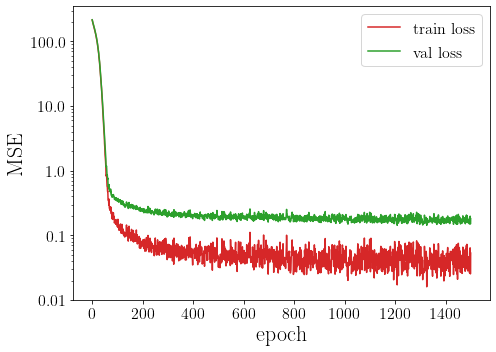

In [89]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses_bn, label="train loss", color=c1 )
axs.plot( val_losses_bn, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "MSE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

As expected, this has not solved the over-fitting problem, but at least you now know how to implement batch norm!

### Using combinations of these methods

Here we have looked at each of these regularisation methods individually, however they work best when used together.  For example you could use either dropout or L2 regularisation to stop your network overfitting, then use early stopping to stop the training when the loss has converged.  This way we do not waste computational resources after our network has converged.  We could then make even better use of our computational resources by introducing batch normalisation.

We note that often to get these methods working as you want them to, some research has to be done to find the best hyper-parameters, e.g. the $p$ parameter in dropout, the weight-decay in L2 regularisation, or the patience in early stopping.